In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
import warnings
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import cm
from tqdm import tqdm
import json

%matplotlib inline

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
pd.set_option('max_rows', 50)

In [2]:
path_pools = '../data/all_selected'

BOUNDARIES = [0, 1000, 10000, 50000, 100000, 200000, 500000, 1000000, 10000000, 1000000000]
N_RANGES = len(BOUNDARIES) - 1
MIN_SAMPLES = 40

In [3]:
POOLS = []
for folder_name in tqdm(os.listdir(path_pools)):
    pool_folder = os.path.join(path_pools, folder_name)
    pool_config = os.path.join(pool_folder, 'config.json')
    
    if not os.path.isdir(pool_folder) or not os.path.isfile(pool_config):
        print('Invalid pool folder:', pool_folder, pool_config)
        continue
        
    with open(pool_config) as f:
        config = json.loads(f.read())
        
        token0 = config['token0']
        token1 = config['token1']
        stable_index = config['stable_index']
        
        if stable_index == 0:
            token0, token1 = token1, token0
        
        POOLS.append((token0, token1, stable_index))

100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:01<00:00, 212.88it/s]


In [4]:
print("Number of pools:", len(POOLS))

Number of pools: 244


In [5]:
def get_pool_index(x_name, y_name):
    for i in range(len(POOLS)):
        if POOLS[i][0] == x_name and POOLS[i][1] == y_name:
            return i

In [6]:
def filter_mev(swaps_df, X_NAME, Y_NAME):
    grouped = swaps_df.groupby('timestamp')
    l=None

    y_values = []
    txds = []

    for name, group in grouped:
        if len(group) <= 2:
            continue

        x_swaps = group[group.token_in == X_NAME]
        y_swaps = group[group.token_in == Y_NAME]


        for index, row in x_swaps.iterrows():
            if row['amount_out'] in y_swaps.amount_in.values:
                s = y_swaps[y_swaps.amount_in == row['amount_out']].iloc[0] # todo: assert length

                if row['amount_in'] < s['amount_out']:
                    y_values.append(s['amount_in'])
                    txds.append(s['txd'])
                    txds.append(row['txd'])



        for index, row in y_swaps.iterrows():
            if row['amount_out'] in x_swaps.amount_in.values:
                s = x_swaps[x_swaps.amount_in == row['amount_out']].iloc[0] # todo: assert length

                if row['amount_in'] < s['amount_out']:
                    y_values.append(row['amount_in'])
                    txds.append(s['txd'])
                    txds.append(row['txd'])  
                    
    filtered_swaps_df = swaps_df[~swaps_df.txd.isin(txds)]
    mevs_df = swaps_df[swaps_df.txd.isin(txds)]
    #print(f'Initial swaps count: {len(swaps_df)}\nAfter filtering mevs: {len(filtered_swaps_df)}')
    
    return filtered_swaps_df, mevs_df

In [7]:
def filter_suspicious_transactions(swaps_df, X_NAME, Y_NAME):
    '''
    Filters transaction pairs initited by the same sender and executed in the same block, 
    where each transaction inside the pair is in a distinct direction and the percentage difference of in/out values is less than 5%
    
    Filtered transactions types: MEV transactions, Token extraction and subsequent return in consecutive transaction 
    (e.g.: for executing MEV attack on a pool with this token on some other platform)
    '''
    grouped = swaps_df.groupby(['timestamp', 'sender'])
    
    y_values = []
    txds = []
    
    for name, group in grouped:
        if len(group) != 2:
            continue
            
        s0 = group.iloc[0]
        s1 = group.iloc[1]
        
        if s0.token_in == s1.token_in:
            continue
            
        in0 = s0.amount_in
        in1 = s1.amount_in
        
        out0 = s0.amount_out
        out1 = s1.amount_out
        
        perc_diff0 = abs(out1 - in0) / ((out1 + in0) / 2) * 100
        perc_diff1 = abs(out0 - in1) / ((out0 + in1) / 2) * 100
        
        if perc_diff0 <= 5 or perc_diff1 <=5:
            txds.extend([s0.txd, s1.txd])
            
    filtered_swaps_df = swaps_df[~swaps_df.txd.isin(txds)]
    suspicious_df = swaps_df[swaps_df.txd.isin(txds)]

    #print(f'After filtering sp: {len(filtered_swaps_df)}\n')


    return filtered_swaps_df, suspicious_df

In [8]:
from pprint import pprint

def count_mev_pairs(swaps_df, X_NAME, Y_NAME):
    grouped = swaps_df.groupby('timestamp')
    l=None

    y_values = []
    txds = []

    for name, group in grouped:
        if len(group) <= 2:
            continue

        x_swaps = group[group.token_in == X_NAME]
        y_swaps = group[group.token_in == Y_NAME]


        for index, row in x_swaps.iterrows():
            if row['amount_out'] in y_swaps.amount_in.values:
               # print(row)
                s = y_swaps[y_swaps.amount_in == row['amount_out']].iloc[0]

                if row['amount_in'] < s['amount_out']:
                    y_values.append(s['amount_in'])
                    txds.append(s['txd'])
                    txds.append(row['txd'])



        for index, row in y_swaps.iterrows():
            if row['amount_out'] in x_swaps.amount_in.values:
                s = x_swaps[x_swaps.amount_in == row['amount_out']].iloc[0]

                if row['amount_in'] < s['amount_out']:
                    y_values.append(row['amount_in'])
                    txds.append(s['txd'])
                    txds.append(row['txd'])  
                    
    return len(txds) // 2

## Load Data

In [9]:
import datetime

swaps = {}
removed_swaps = {}

idx = 0

for X_NAME, Y_NAME, stable_index in tqdm(POOLS):
    x_name, y_name = X_NAME, Y_NAME
    if stable_index == 0:
        x_name, y_name = Y_NAME, X_NAME
    swaps_df = pd.read_pickle(f'../data/all_selected/{x_name}_{y_name}/{x_name}_{y_name}_swaps.pkl')
    swaps_df = swaps_df[swaps_df.timestamp >= datetime.datetime(2020, 5, 1, 0, 0, 0)] # filter out period with law gas prices
    reserves_df = pd.read_pickle(f'../data/all_selected/{x_name}_{y_name}/{x_name}_{y_name}_reserves.pkl')
   
    reserves_df['reserve_stablecoin'] = reserves_df[f'reserve{stable_index}']
    reserves_df['reserve_stablecoin_prev'] = reserves_df[f'reserve{stable_index}'].shift(1)
    reserves_df['reserve_stablecoin_next'] = reserves_df[f'reserve{stable_index}'].shift(-1)
    #reserves_df = reserves_df[(reserves_df['reserve_stablecoin_next'] - reserves_df['reserve_stablecoin']).abs()/((reserves_df['reserve_stablecoin_next'] + reserves_df['reserve_stablecoin'])/2) < 0.3]
    reserves_df = reserves_df[(reserves_df['reserve_stablecoin_prev'] - reserves_df['reserve_stablecoin']).abs()/((reserves_df['reserve_stablecoin_prev'] + reserves_df['reserve_stablecoin'])/2) < 0.3]

    
    merged_df = swaps_df.merge(reserves_df, left_on=[swaps_df.timestamp.dt.year, swaps_df.timestamp.dt.month, swaps_df.timestamp.dt.day], 
                                     right_on=[reserves_df.date.dt.year, reserves_df.date.dt.month, reserves_df.date.dt.day], how='inner')
    merged_df.loc[merged_df.token_in == Y_NAME, 'reserveRatio'] = merged_df.loc[merged_df.token_in == Y_NAME, 'amount_in'] / merged_df.loc[merged_df.token_in == Y_NAME, f'reserve{stable_index}']  
   # print(X_NAME, Y_NAME)
    

        
    #if X_NAME == 'WBTC' and Y_NAME == 'USDC':
    merged_df, removed1 = filter_mev(merged_df, X_NAME, Y_NAME)
    merged_df, removed2 = filter_suspicious_transactions(merged_df, X_NAME, Y_NAME)
    swaps[idx] = merged_df
    
    removed1['type'] = 'MEV'
    removed2['type'] = 'SP'
    removed_swaps[idx] = pd.concat([removed1, removed2])
    idx += 1

100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [05:02<00:00,  1.24s/it]


In [10]:
def get_pools_count_in_range(a, b):
    cnt = 0
    for key, df in swaps.items():
        x_name, y_name, stable_index = POOLS[key]
        
        range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
        range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
        amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in
        count = len(amount_in_values)

        if count >= MIN_SAMPLES:
            cnt += 1
            
    return cnt

#### Histograms for each reserve range

Range: [0 - 1000]


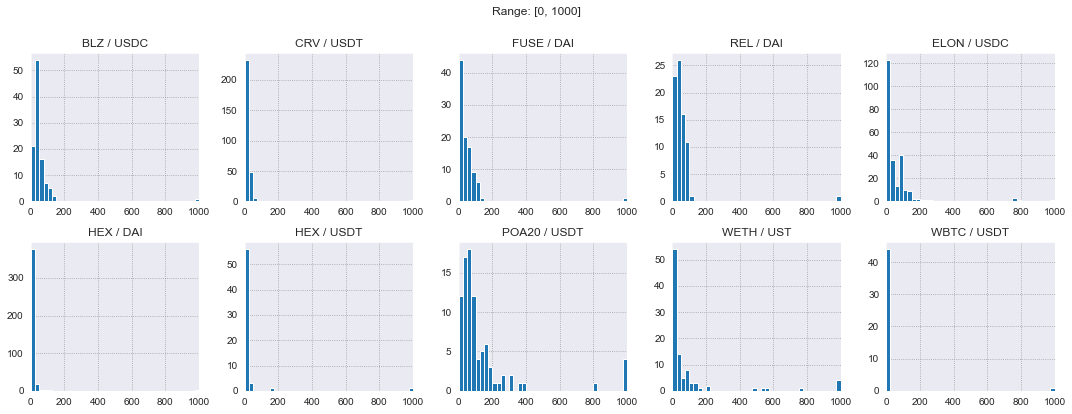

In [11]:
X_MAX_LIST = [1000, 3000, 10000, 15000, 20000, 25000, 30000, 100000, 150000]

reserve_i = 0
for a, b in zip(BOUNDARIES[:-1], BOUNDARIES[1:]):    
    print(f'Range: [{a} - {b}]')
    n_pools = get_pools_count_in_range(a, b)
    COLS = 5
    ROWS = n_pools//COLS + (n_pools % COLS != 0)

    fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*3, ROWS*3))
    ax = ax.ravel()
    
    X_MAX = X_MAX_LIST[reserve_i]
    
    i = 0
    for key, df in swaps.items():
        x_name, y_name, stable_index = POOLS[key]
        
        range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
        range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
        amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in.values
        count = len(amount_in_values)        

        if count < MIN_SAMPLES:
            continue
            
        values = amount_in_values.copy()
        values[values > X_MAX] = X_MAX
        values = np.append(values, X_MAX)
        
        ax[i].hist(values, bins=40)
        ax[i].set_title(f'{x_name} / {y_name}')
        ax[i].set_xlim(0, X_MAX)
        i += 1

    fig.suptitle(f'Range: [{a}, {b}]') 
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    reserve_i += 1
    
    break

In [12]:
def compute_errors(amount_in_values, dist, fitted_params_cnt):
    if len(amount_in_values) < MIN_SAMPLES:
        mae=None
        sq_error=None
        AIC=None
    else:
        bin_width = 1000
        bins_count = max(20, int(max(amount_in_values) // bin_width))

        y, x = np.histogram(amount_in_values, bins=bins_count, density=True)
        x = [(this + x[i + 1]) / 2.0 for i, this in enumerate(x[0:-1])]

        pdf_fitted_bins = dist.pdf(x)

        pdf = dist.pdf(amount_in_values)

        sq_error = sum((pdf_fitted_bins - y) ** 2)
        mae = sum(abs(pdf_fitted_bins - y))
        logLik = np.sum(dist.logpdf(amount_in_values))

        k = fitted_params_cnt
        AIC = 2*k - 2*logLik

    return sq_error, mae, AIC

### Identification of best-fit trade size distribution
#### Compared distributions: Lognormal, Weibull, Gamma, HalfCauchy

In [13]:
def plot_pdf(dist, label, x_limit, ax):
    x = np.linspace(0, x_limit, 1000)
    y = dist.pdf(x)
    
    ax.plot(x, y, label=label)

Range: [0 - 1000]


NameError: name 'dist_list' is not defined

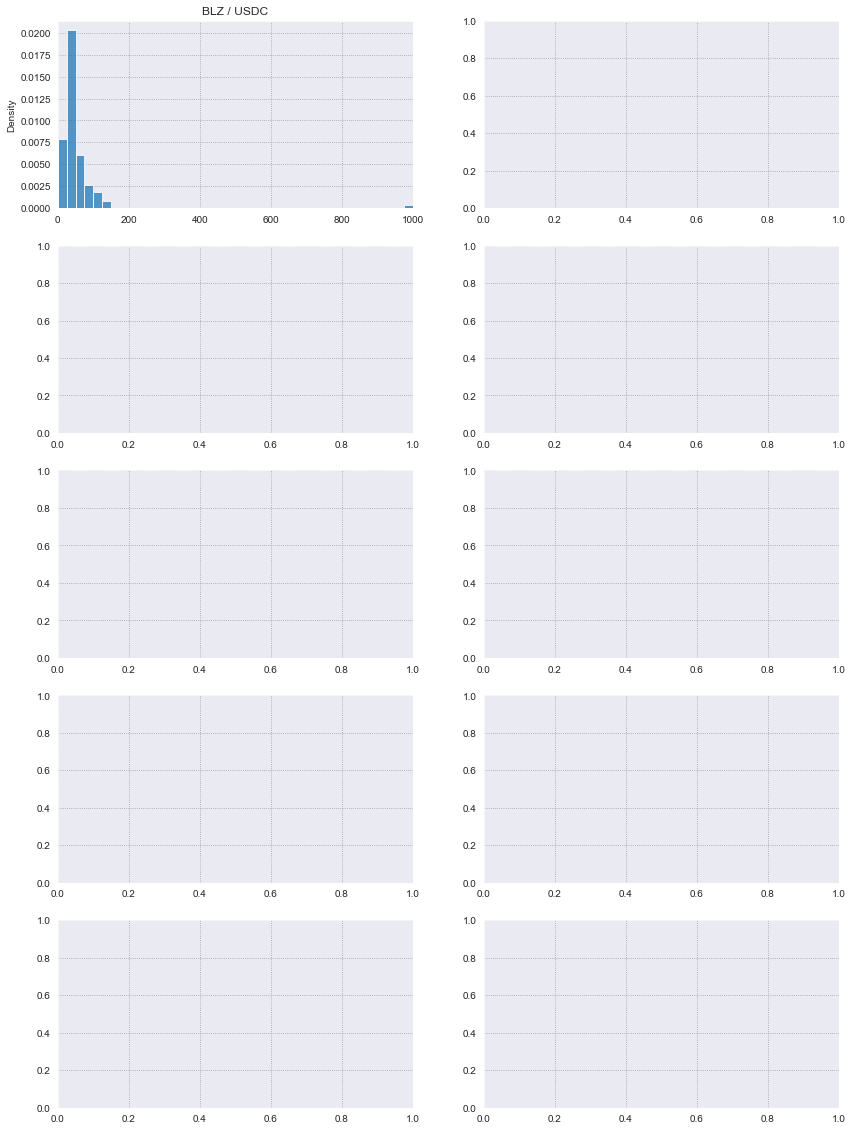

In [14]:
X_MAX_LIST = [1000, 3000, 10000, 15000, 20000, 25000, 30000, 100000, 150000]

reserve_i = 0
for a, b in zip(BOUNDARIES[:-1], BOUNDARIES[1:]):    
    print(f'Range: [{a} - {b}]')
    n_pools = get_pools_count_in_range(a, b)
    COLS = 2
    ROWS = n_pools//COLS + (n_pools % COLS != 0)

    fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*7, ROWS*4))
    ax = ax.ravel()
    
    X_MAX = X_MAX_LIST[reserve_i]
    
    i = 0
    for key, df in swaps.items():
        x_name, y_name, stable_index = POOLS[key]
        
        range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
        range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
        amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in.values
        count = len(amount_in_values)        

        if count < MIN_SAMPLES:
            continue
            
        values = amount_in_values.copy()
        values[values > X_MAX] = X_MAX
        values = np.append(values, X_MAX)
        
        sns.histplot(data=values, bins=40,  ax=ax[i], stat='density')
        ax[i].set_title(f'{x_name} / {y_name}')
        ax[i].set_xlim(0, X_MAX)
        
        
        for j, dist in enumerate(dist_list):
            fitted_params = dist.fit(amount_in_values, method='mle', floc=0)
            loc, scale = fitted_params[-2], fitted_params[-1]
            dist_args = fitted_params[:-2]

            plot_pdf(dist(*fitted_params), dist_names[j] if i == 0 else None, X_MAX, ax[i])
        i += 1

    fig.suptitle(f'Range: [{a}, {b}]') 
    fig.tight_layout(rect=[0, 0.03, 1, 0.99])
    fig.legend()
    reserve_i += 1

In [80]:
# Compare distributions (QQ-plot)

dist_list = [scipy.stats.weibull_min, scipy.stats.gamma, scipy.stats.lognorm, scipy.stats.halfcauchy]
dist_names = ['Weibull', 'Gamma', 'LogNormal', 'HalfCauchy']
errors_df = pd.DataFrame(columns=['pool','reserves_lower_limit','reserves_upper_limit', 'dist', 'AIC', 'SSE', 'MAE', ])

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for a, b in zip(BOUNDARIES[:-1], BOUNDARIES[1:]):    
        print(f'Reserve range: [{a} - {b}]')

        for key, df in swaps.items():
            x_name, y_name, stable_index = POOLS[key]

            range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
            range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
            amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in.values
            count = len(amount_in_values)

            shape, loc, scale = None, None, None 

            if count < MIN_SAMPLES:
                continue

            COLS = len(dist_list)
            ROWS = 1
#             fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
#             ax = ax.ravel()

            for j, dist in enumerate(dist_list):
                fitted_params = dist.fit(amount_in_values, method='mle', floc=0)
                loc, scale = fitted_params[-2], fitted_params[-1]
                dist_args = fitted_params[:-2]

#                 sm.qqplot(amount_in_values, dist, distargs=dist_args, loc=loc, scale=scale, line="45", ax=ax[j], markersize=2)
#                 ax[j].set_xlabel(f'{dist_names[j]} Distribution Quantiles')

                sq_error, mae, AIC = compute_errors(amount_in_values, dist(*fitted_params), len(fitted_params) - 1)

                ax[j].set_title(f'AIC: {AIC:.2f}, SSE: {sq_error:.3g}')
                errors_df.loc[len(errors_df)] = [x_name + '/' + y_name, a, b, dist_names[j], AIC, sq_error, mae]

#             fig.suptitle(f'Pool {x_name}/{y_name}, Reserves range: [{a}, {b}]') 

#             fig.tight_layout()

Reserve range: [0 - 1000]
Reserve range: [1000 - 10000]
Reserve range: [10000 - 50000]
Reserve range: [50000 - 100000]
Reserve range: [100000 - 200000]
Reserve range: [200000 - 500000]
Reserve range: [500000 - 1000000]
Reserve range: [1000000 - 10000000]
Reserve range: [10000000 - 1000000000]


In [81]:
min_errors_df = errors_df.groupby(['reserves_lower_limit', 'reserves_upper_limit', 'pool'])[['AIC', 'SSE', 'MAE']].min().add_prefix('min_').reset_index()

errors_df = errors_df.merge(min_errors_df)

errors_df.loc[:, 'AIC_score'] = 0
errors_df.loc[:, 'MAE_score'] = 0
errors_df.loc[:, 'SSE_score'] = 0
errors_df.loc[errors_df['AIC'] == errors_df['min_AIC'], 'AIC_score'] = 1
errors_df.loc[errors_df['MAE'] == errors_df['min_MAE'], 'MAE_score'] = 1
errors_df.loc[errors_df['SSE'] == errors_df['min_SSE'], 'SSE_score'] = 1

In [82]:
errors_df.groupby(['dist', 'reserves_upper_limit']).sum()

AIC           SSE       MAE  \
dist       reserves_upper_limit                                         
Gamma      1000                  1.175930e+04  4.455997e-01  1.448734   
           10000                 1.263363e+05  5.869244e-04  0.248737   
           50000                 6.149313e+05  2.958039e-05  0.089499   
           100000                7.381238e+05  2.035364e-05  0.074518   
           200000                1.098677e+06  1.315907e-05  0.070183   
           500000                2.483720e+06  2.715867e-06  0.039774   
           1000000               2.877178e+06  1.936439e-06  0.033394   
           10000000              6.144334e+06  1.997578e-06  0.040050   
           1000000000            3.610528e+06  1.058162e-06  0.022580   
HalfCauchy 1000                  1.214963e+04  2.487041e-01  1.151651   
           10000                 1.276525e+05  9.152507e-04  0.279067   
           50000                 6.219097e+05  4.766339e-05  0.116854   
           100000                7.464469e+05  2.334918e-05  0.089129   
           200000                1.111327e+06  1.220960e-05  0.079697   
           500000                2.505224e+06  3.375129e-06  0.047496   
           1000000               2.898804e+06  1.793952e-06  0.036600   
           10000000              6.171003e+06  1.590437e-06  0.041755   
           1000000000            3.606111e+06  6.555231e-07  0.021273   
LogNormal  1000                  1.222106e+04  4.627235e-01  1.512187   
           10000                 1.292599e+05  6.984870e-04  0.293462   
           50000                 6.245478e+05  5.748477e-05  0.121639   
           100000                7.476983e+05  2.760739e-05  0.094588   
           200000                1.111322e+06  1.494143e-05  0.086214   
           500000                2.506320e+06  4.376327e-06  0.050830   
           1000000               2.898220e+06  2.068252e-06  0.037942   
           10000000              6.163639e+06  1.575738e-06  0.039607   
           1000000000            3.597997e+06  6.089476e-07  0.020329   
Weibull    1000                  1.163763e+04  3.953483e-01  1.381737   
           10000                 1.258311e+05  6.536304e-04  0.249833   
           50000                 6.139518e+05  2.845770e-05  0.087604   
           100000                7.377624e+05  1.743341e-05  0.072097   
           200000                1.098095e+06  1.133279e-05  0.067222   
           500000                2.482739e+06  2.440571e-06  0.038351   
           1000000               2.875246e+06  1.702705e-06  0.032148   
           10000000              6.132328e+06  1.636613e-06  0.037553   
           1000000000            3.592736e+06  7.964208e-07  0.020781   

                                      min_AIC       min_SSE   min_MAE  \
dist       reserves_upper_limit                                         
Gamma      1000                  1.156397e+04  2.480393e-01  1.137063   
           10000                 1.257044e+05  4.638501e-04  0.226450   
           50000                 6.136491e+05  2.602492e-05  0.083987   
           100000                7.373726e+05  1.261366e-05  0.065107   
           200000                1.097778e+06  8.085218e-06  0.060972   
           500000                2.482281e+06  1.927183e-06  0.035271   
           1000000               2.874458e+06  1.304209e-06  0.029421   
           10000000              6.125805e+06  1.138676e-06  0.033981   
           1000000000            3.582911e+06  4.441062e-07  0.018565   
HalfCauchy 1000                  1.156397e+04  2.480393e-01  1.137063   
           10000                 1.257044e+05  4.638501e-04  0.226450   
           50000                 6.136491e+05  2.602492e-05  0.083987   
           100000                7.373726e+05  1.261366e-05  0.065107   
           200000                1.097778e+06  8.085218e-06  0.060972   
           500000                2.482281e+06  1.927183e-06  0.035271   
           1000000        

### Final metric scores:

In [125]:
errors_df.groupby('dist').sum()[['AIC_score', 'MAE_score', 'SSE_score']].reset_index().rename(columns={'dist':'distribution'}).sort_values('AIC_score', ascending=False)

distribution  AIC_score  MAE_score  SSE_score
3      Weibull        341        242        248
0        Gamma        205        188        176
2    LogNormal         71         86         94
1   HalfCauchy         18        119        117

### Weibull distribution
#### QQ plots visual assesment

In [20]:
import statsmodels.api as sm
MIN_SAMPLES = 40
total_cnt = 0



# for a, b in zip(BOUNDARIES[:-1], BOUNDARIES[1:]):    
#     print(f'Range: {a} - {b}')
#     n_pools = get_pools_count_in_range(a, b)
#     COLS = 4
#     ROWS = n_pools * 2
    
#     if ROWS == 0:
#         continue

#     fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*3, ROWS*3))
#     ax = ax.ravel()
    
#     i = 0
#     for key, df in swaps.items():
#         x_name, y_name, stable_index = POOLS[key]
        
#         range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
#         range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
#         amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in.values
#         count = len(amount_in_values)
#         total_cnt += count
        
#         shape, loc, scale = None, None, None 

#         if count < MIN_SAMPLES:
#             continue
            
#         amount_in_values = np.sort(amount_in_values)
#         n_80=count
        
#         shape, loc, scale = stats.weibull_min.fit(amount_in_values, method='mle', floc=0)
#         sm.qqplot(amount_in_values, stats.weibull_min, distargs=(shape,), loc=loc, scale=scale, line="45", ax=ax[i*8], markersize=2)

        
#         for j in range(1, 8):
#             values = stats.weibull_min.rvs(shape, loc=loc, scale=scale, size=len(amount_in_values))
#             sm.qqplot(values, stats.weibull_min, distargs=(shape,), loc=loc, scale=scale, line="45", ax=ax[i*8+j], markersize=2)
            
#         ax[i*8].set_title(f'{x_name} / {y_name}, {count}, range: [{a}, {b}]')

#         i += 1
                                           
#         if i > 16:
#             break
 
        

#     fig.suptitle(f'Range: [{a}, {b}]') 
#     fig.tight_layout()


Range: [0 - 1000]
Range: [1000 - 10000]
Range: [10000 - 50000]
Range: [50000 - 100000]
Range: [100000 - 200000]
Range: [200000 - 500000]
Range: [500000 - 1000000]
Range: [1000000 - 10000000]
Range: [10000000 - 1000000000]


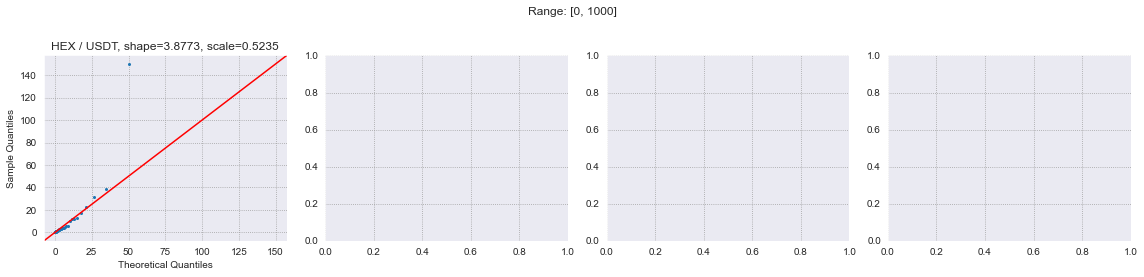

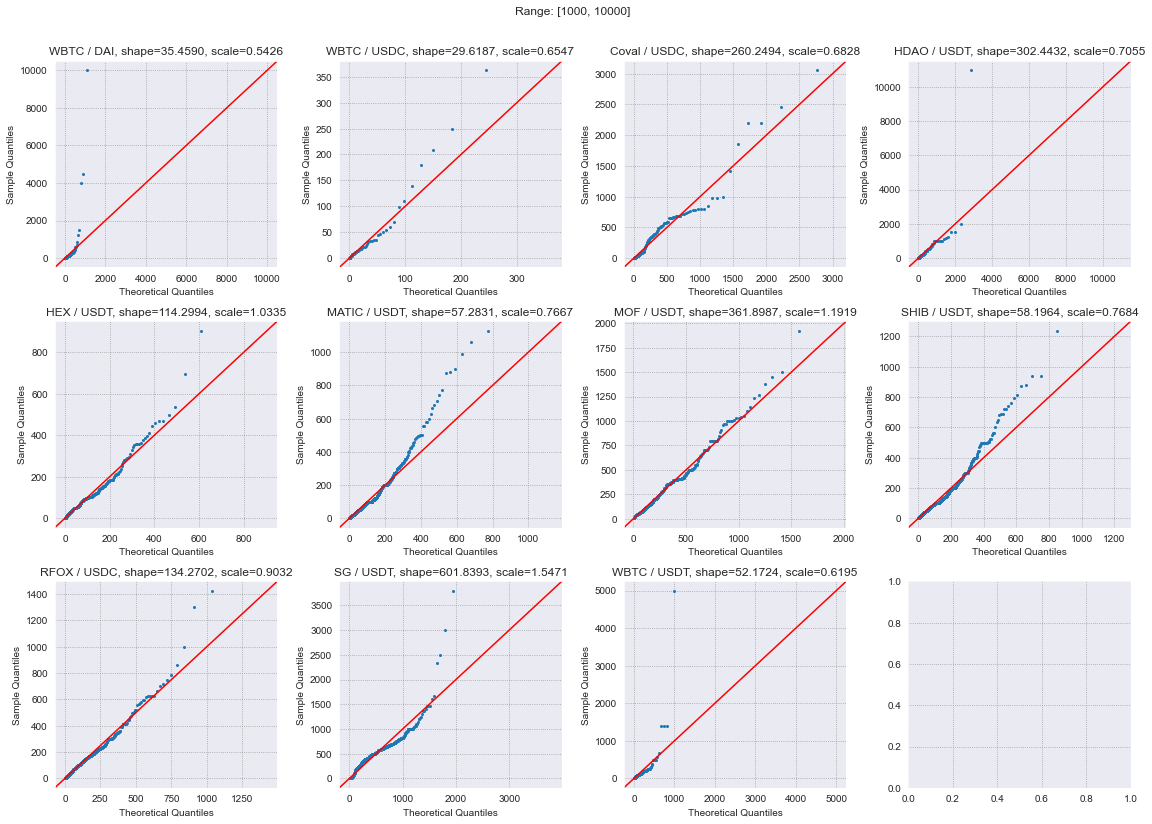

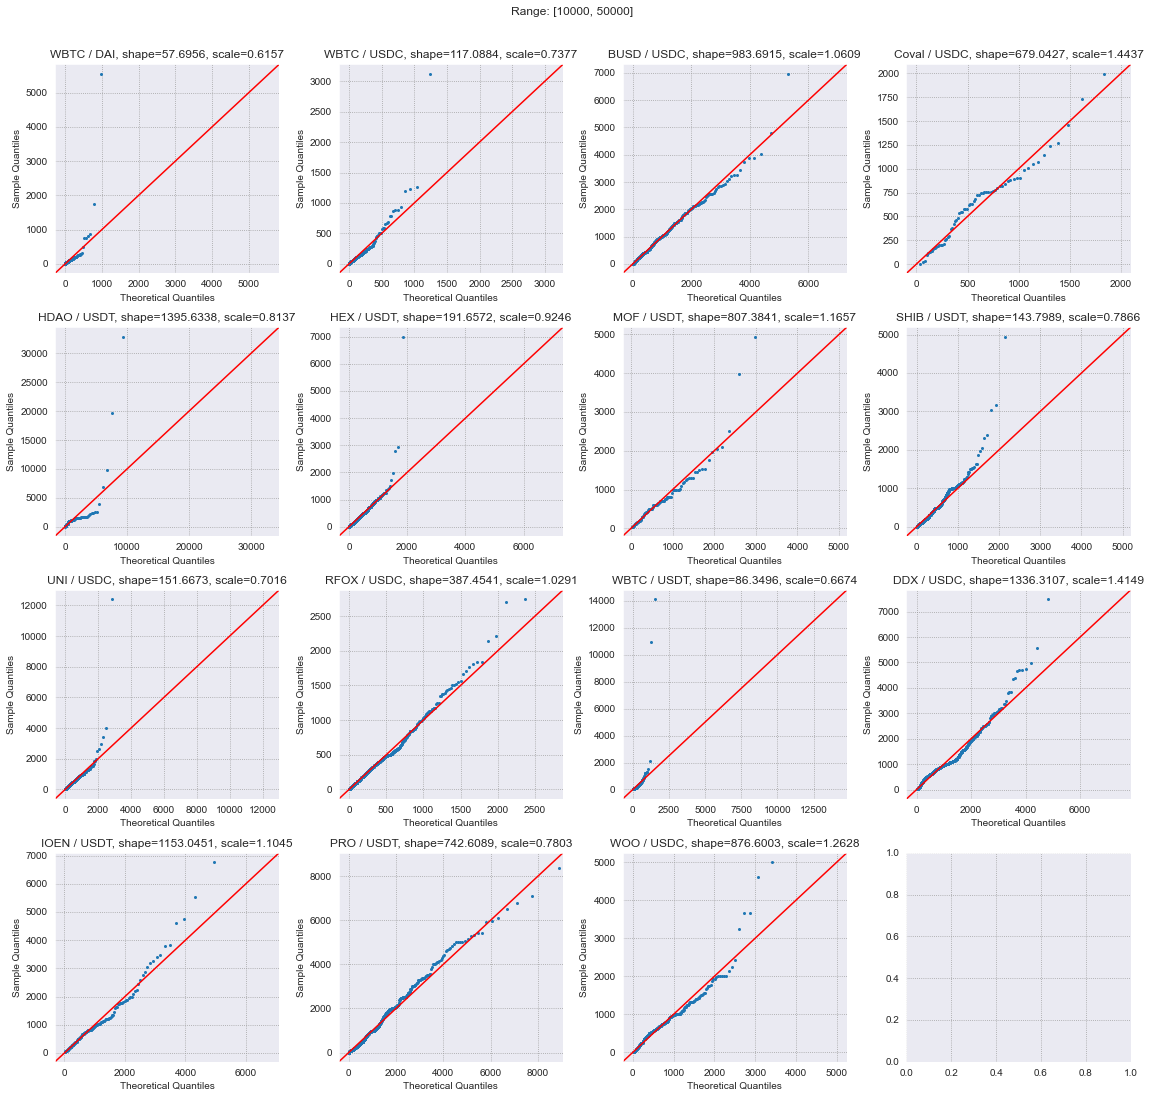

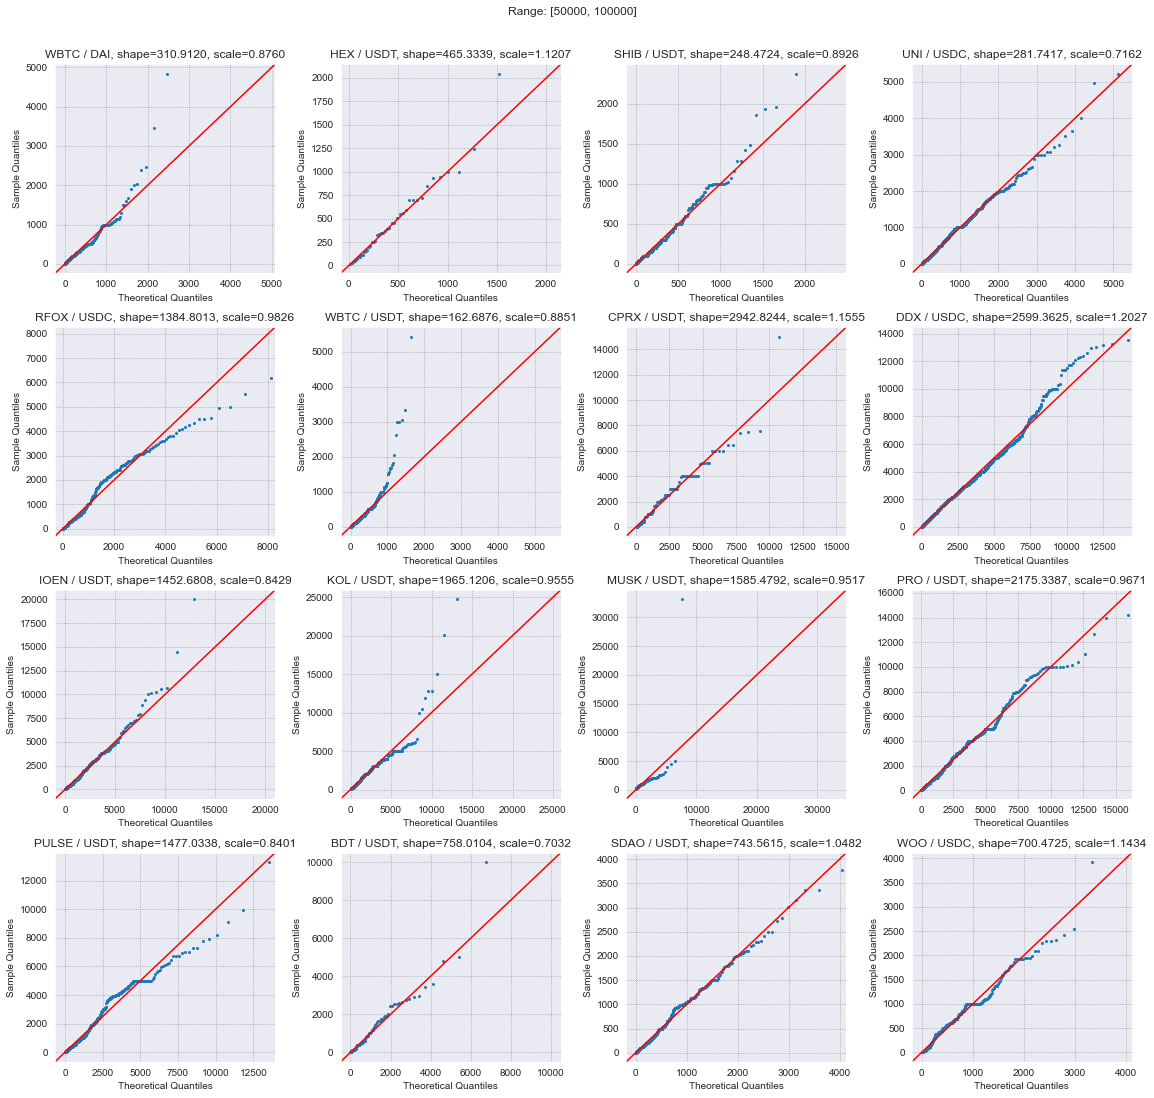

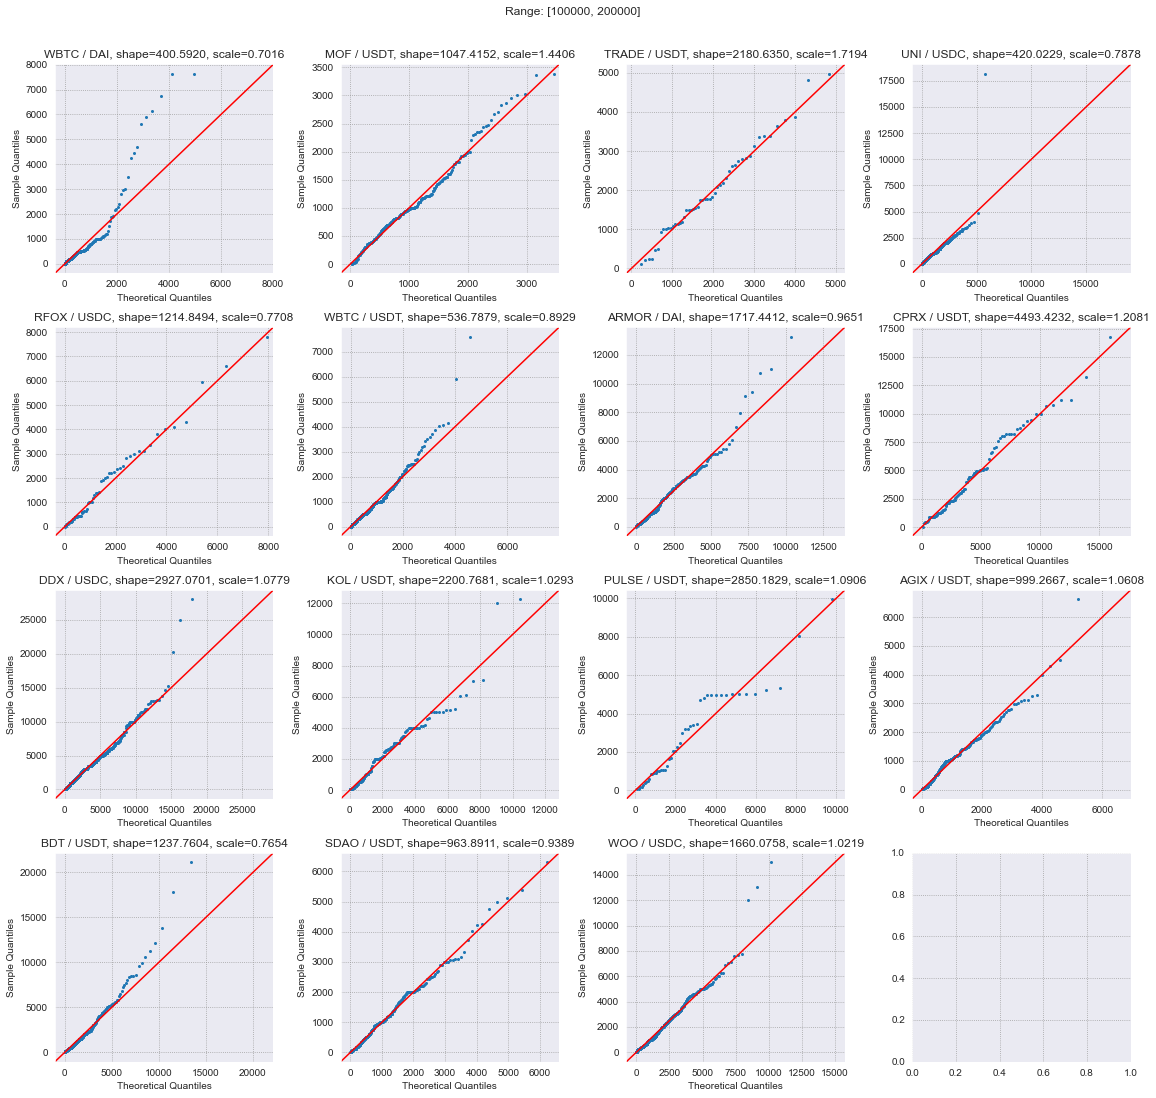

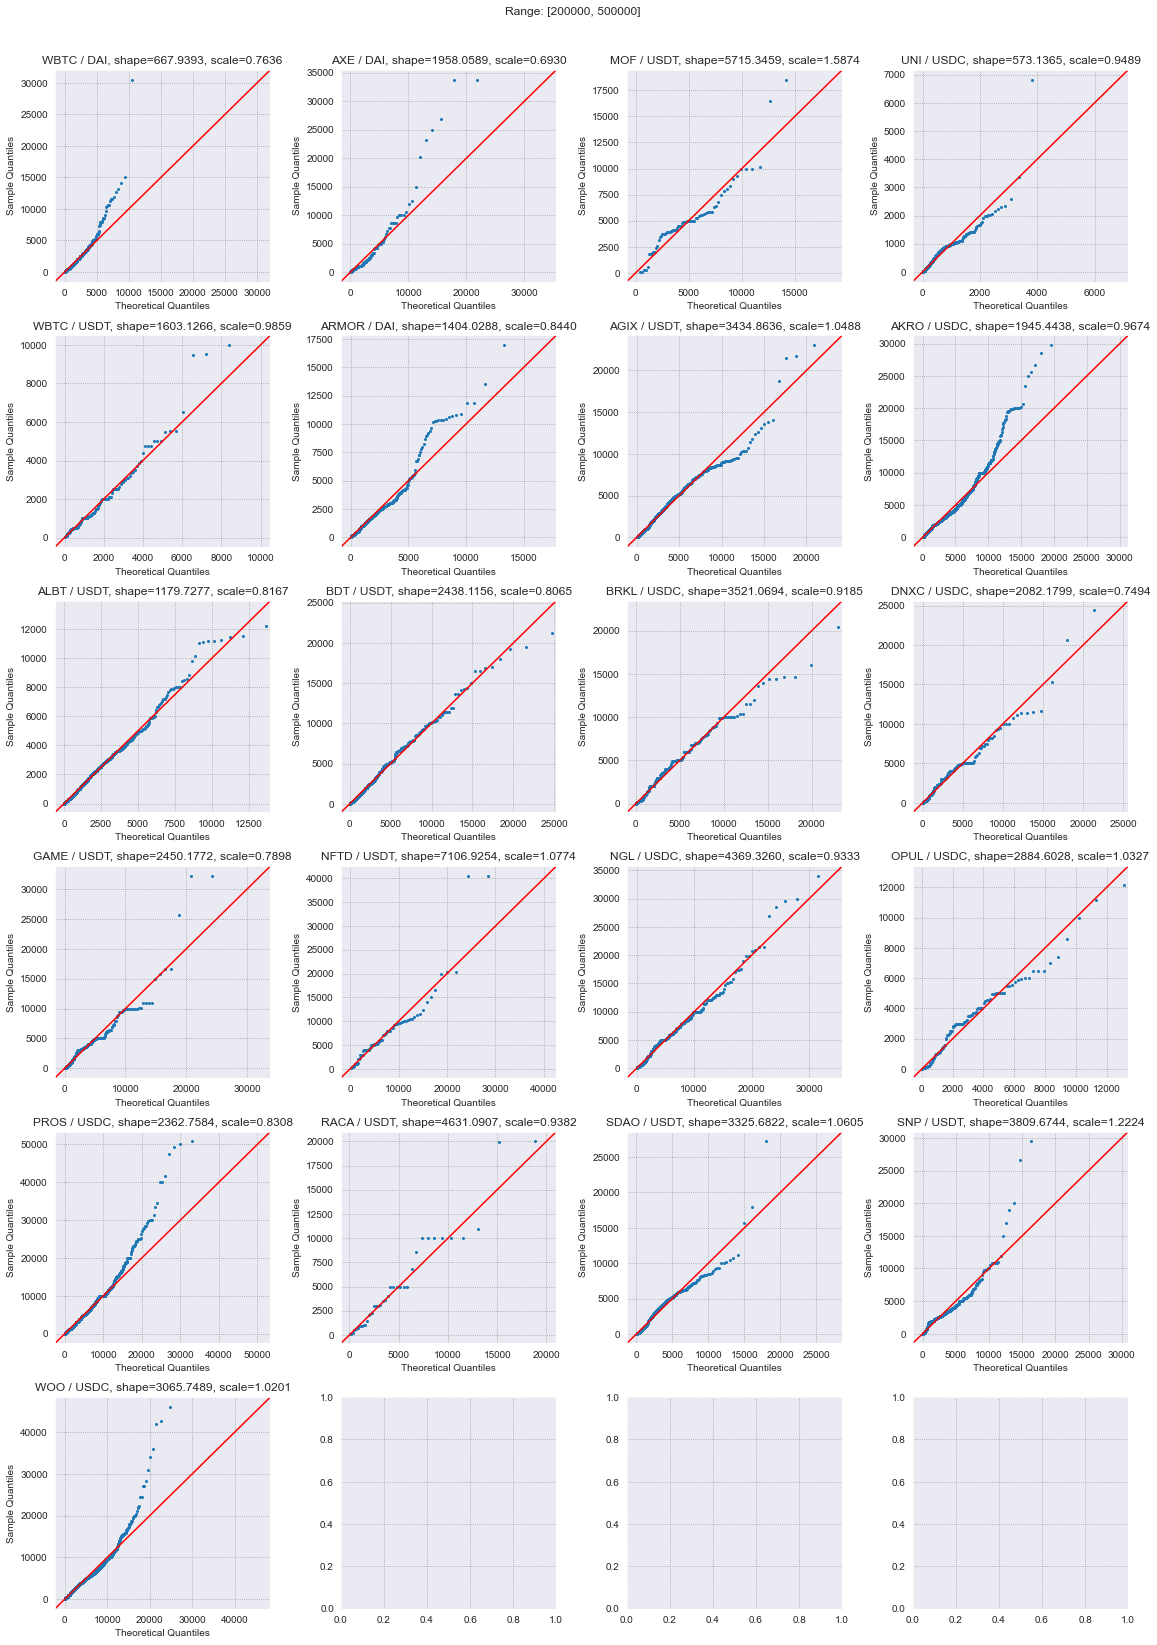

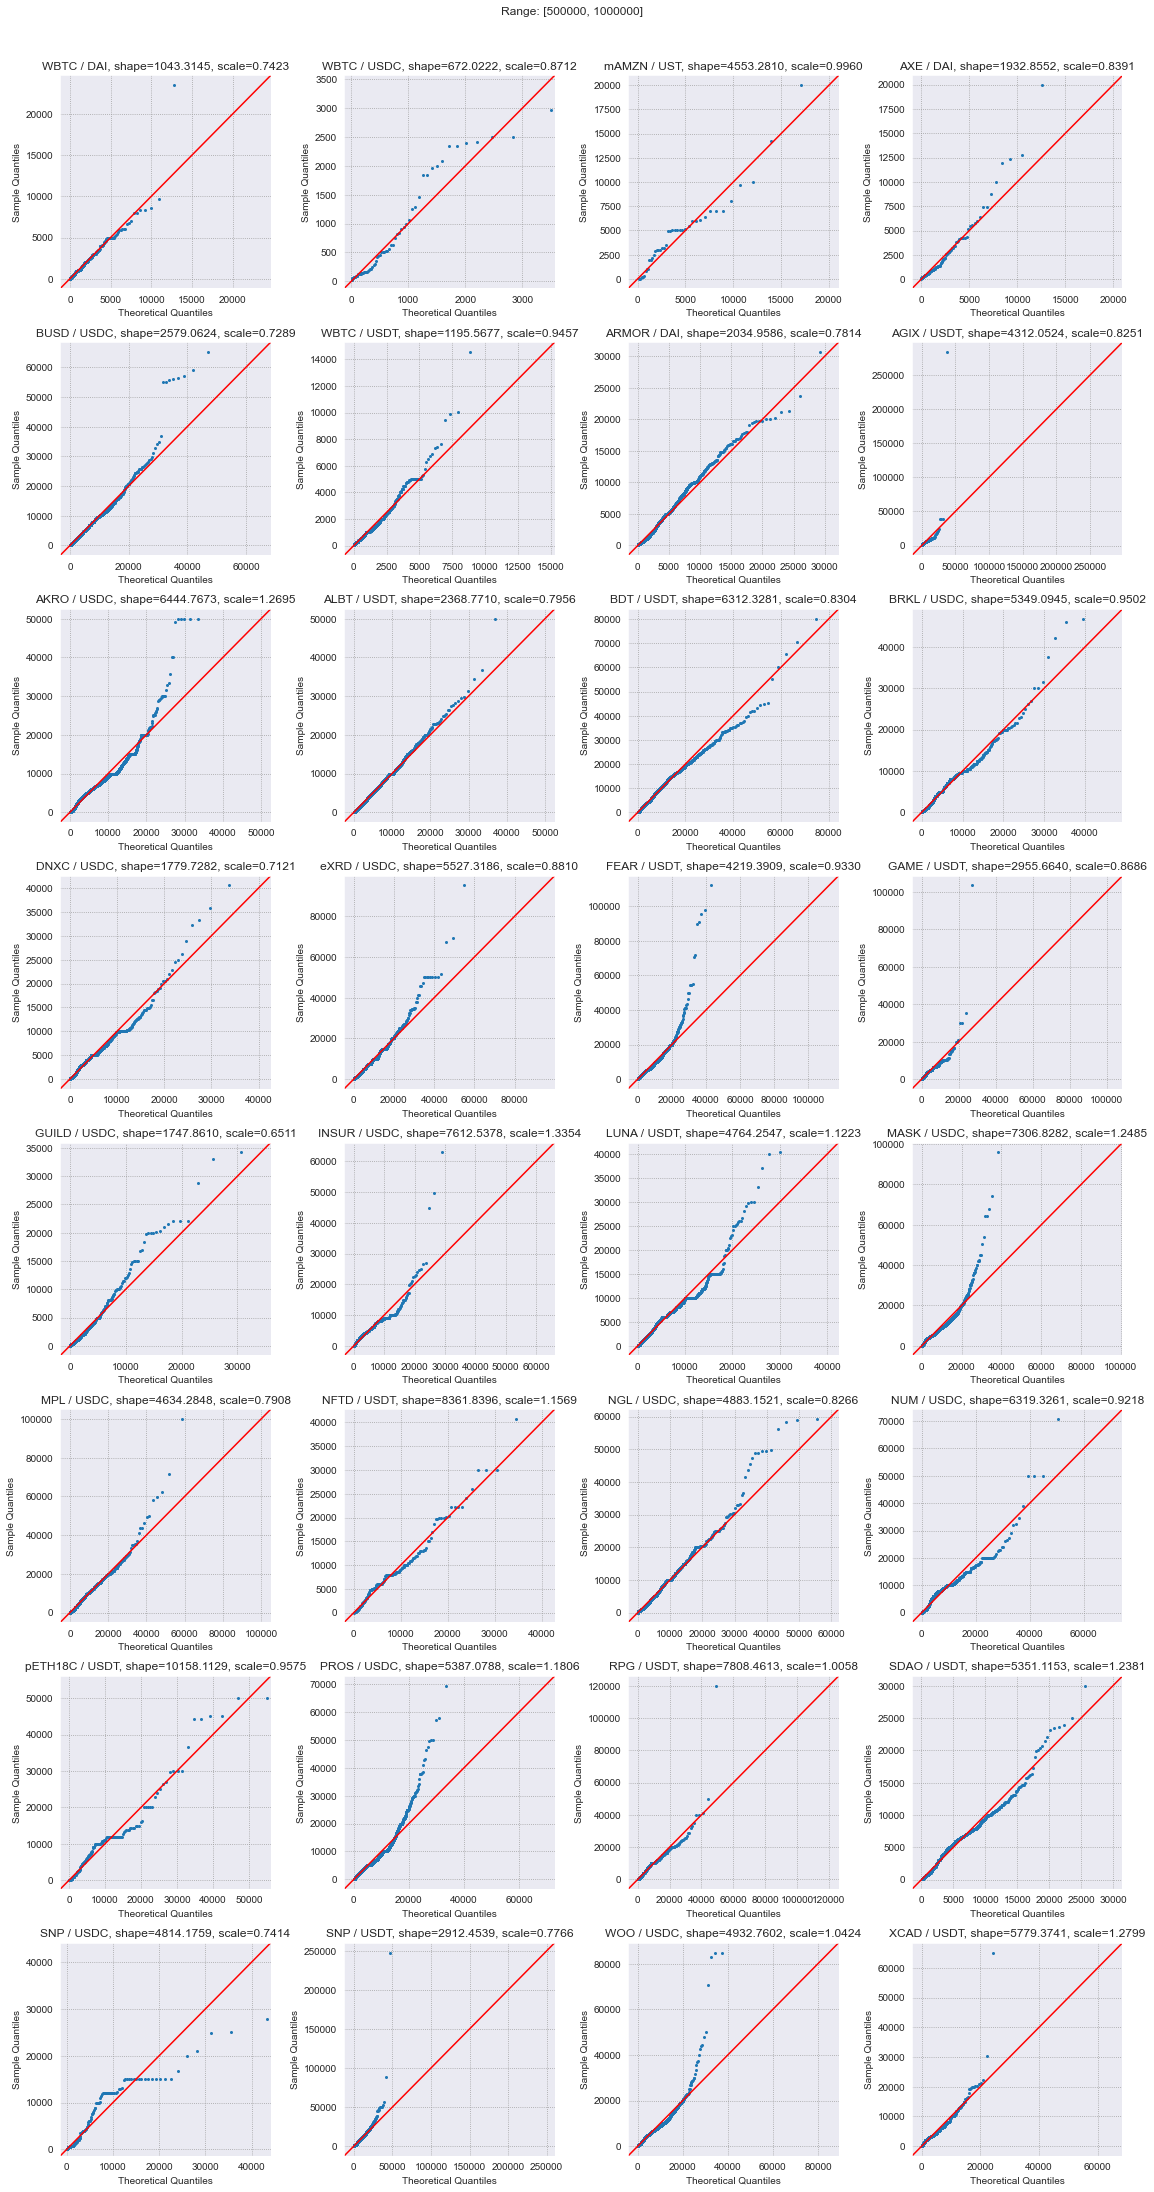

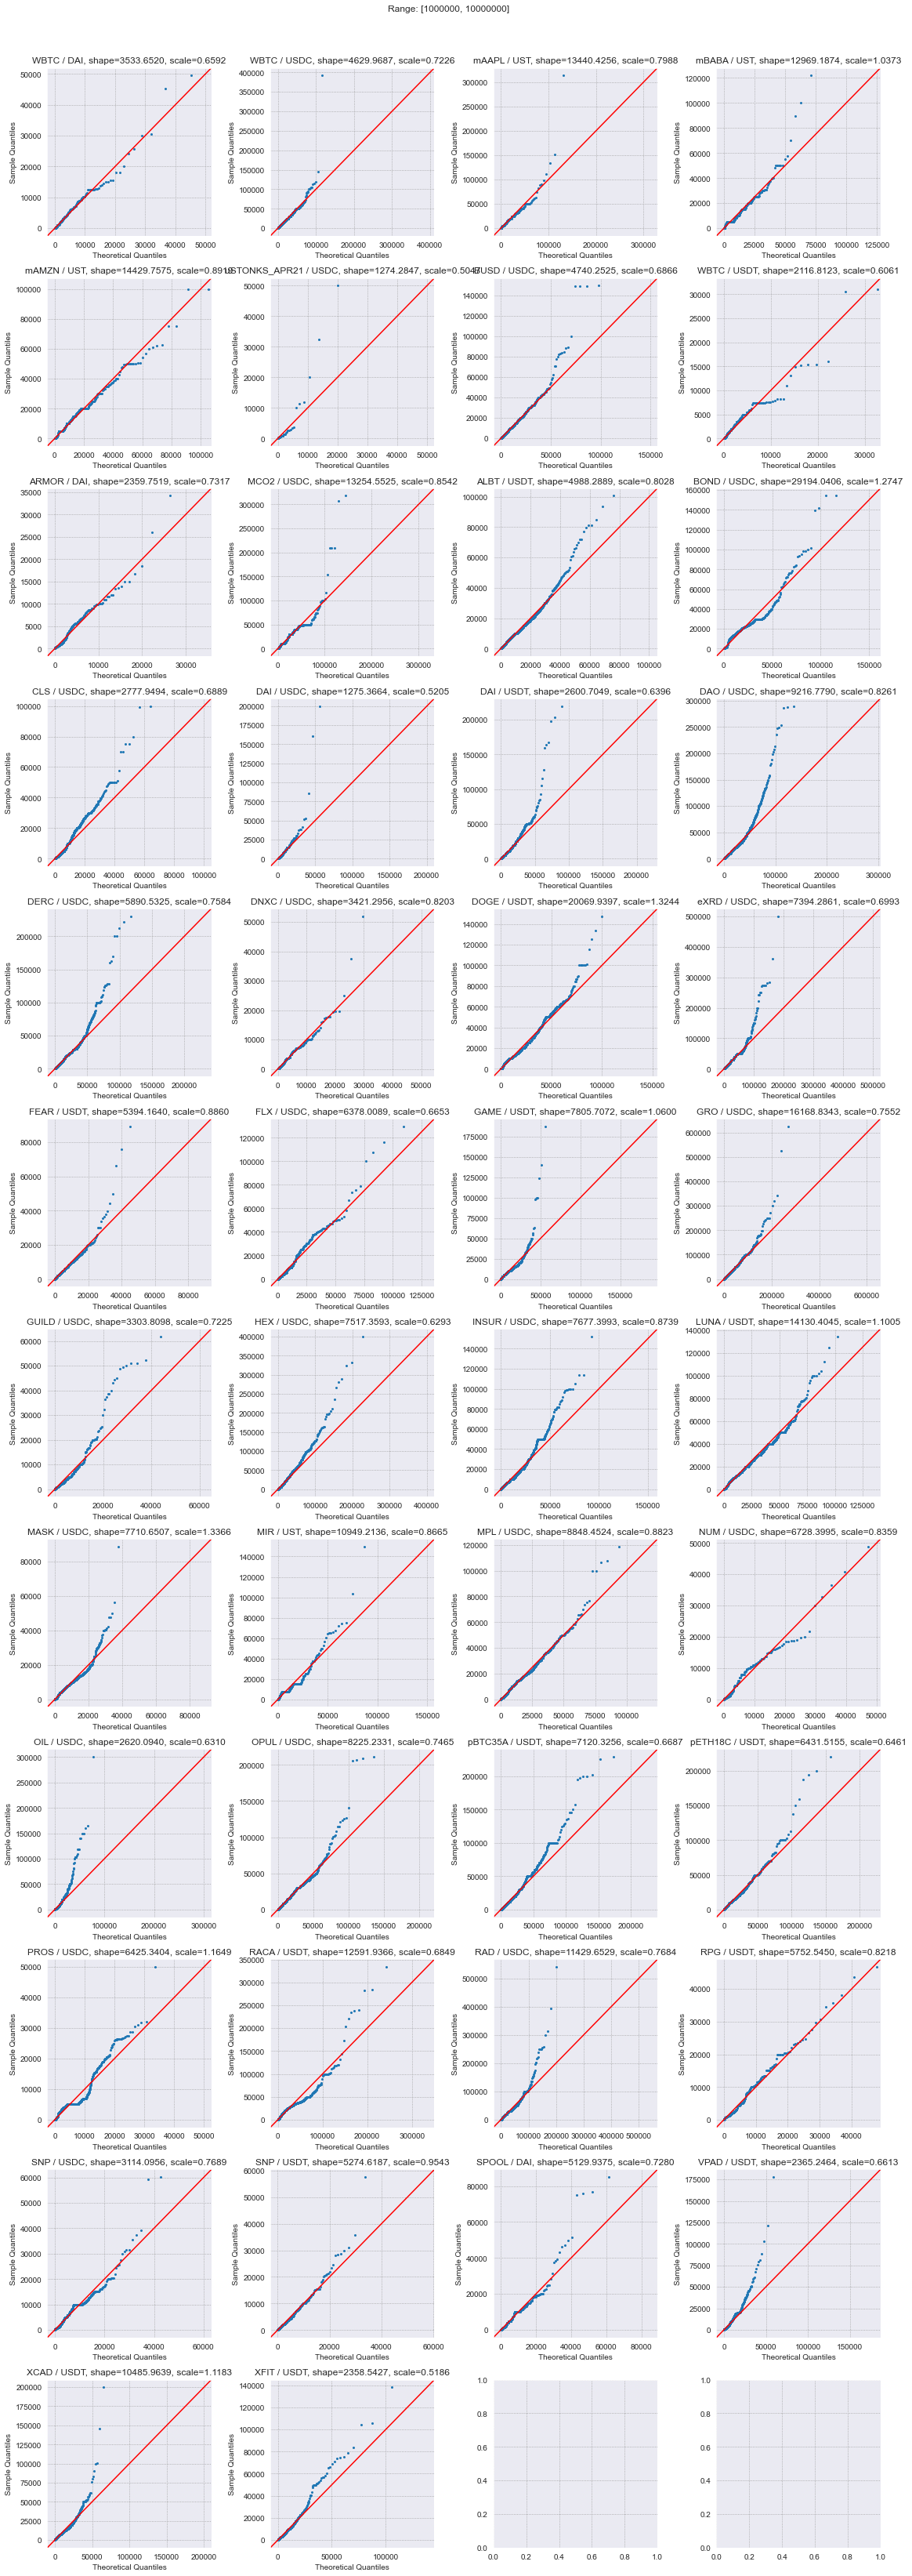

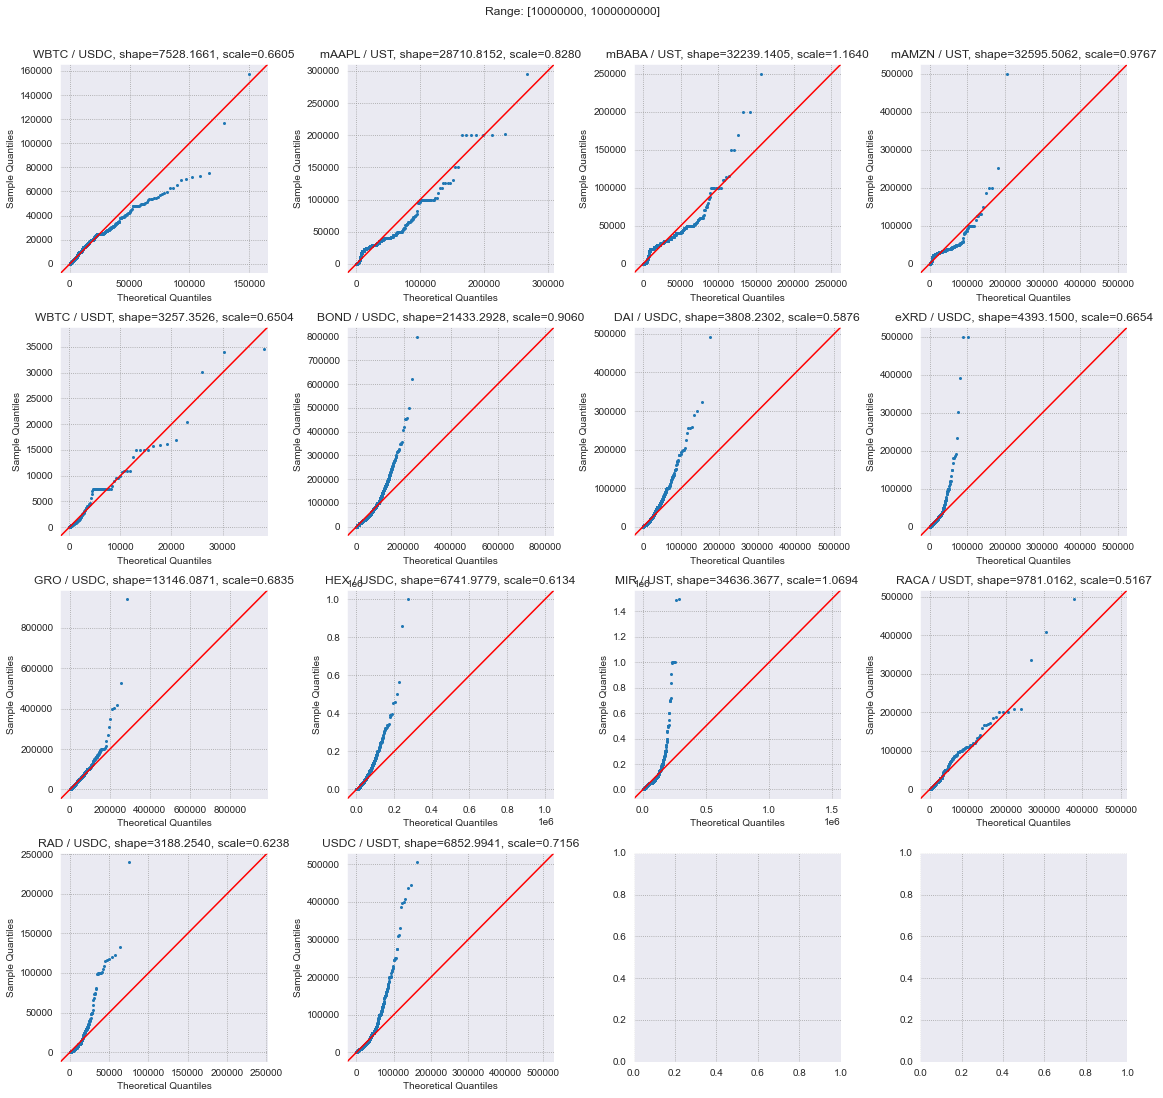

In [287]:
for a, b in zip(BOUNDARIES[:-1], BOUNDARIES[1:]):    
    print(f'Range: [{a} - {b}]')
    n_pools = get_pools_count_in_range(a, b)
    COLS = 4
    ROWS = n_pools // COLS + (n_pools % COLS != 0)
    
    if ROWS == 0:
        continue

    fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
    ax = ax.ravel()
    
    i = 0
    for key, df in swaps.items():
        x_name, y_name, stable_index = POOLS[key]
        # print(x_name, y_name)
        
        range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
        range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
        amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in.values
        count = len(amount_in_values)
        total_cnt += count
        
        shape, loc, scale = None, None, None 

        if count < MIN_SAMPLES:
            continue
            
        amount_in_values = np.sort(amount_in_values)

        shape, loc, scale = stats.weibull_min.fit(amount_in_values, method='mle', floc=0)

        sm.qqplot(amount_in_values, stats.weibull_min, distargs=(shape,), loc=loc, scale=scale, line="45", ax=ax[i], markersize=2)
        
        sq_error, mae, AIC = compute_errors(amount_in_values, stats.weibull_min(shape, loc=loc, scale=scale), 2)
        
        ax[i].set_title(f'{x_name} / {y_name}, shape={scale:.{4}f}, scale={shape:.{4}f}')

        i += 1

    fig.suptitle(f'Range: [{a}, {b}]') 
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

### Weibull Probability Plot

In [261]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 43/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         4.18644          1.2613   2.31949    7.5561
     Beta        0.535048       0.0598366  0.429733  0.666171 

Goodness of fit    Value
 Log-likelihood -111.554
           AICc  227.408
            BIC  230.631
             AD 0.801155 



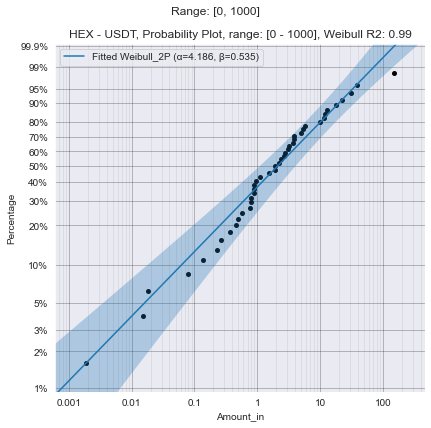

In [232]:
reserve_range_index = 0

for a, b in zip(BOUNDARIES[:-1], BOUNDARIES[1:]):   
    for key, df in swaps.items():
        x_name, y_name, stable_index = POOLS[key]
        
        range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
        range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
        amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in.iloc[:-2]
        
        count = len(amount_in_values)
        total_cnt += count
        
        shape, loc, scale = None, None, None 

        if count < MIN_SAMPLES:
            continue

        fig, ax = plt.subplots()
        fit = Fit_Weibull_2P(failures=amount_in_values.values, downsample_scatterplot=False, method='MLE',)  # fits a Weibull distribution to the data and generates the probability plot
        R2 = compute_weibull_corr_coefficient(amount_in_values.values)
        
        plt.gca().set_xlabel(f'Amount_in')
        plt.gca().set_ylabel('Percentage')
        plt.gca().set_title(f'{x_name} - {y_name}, Probability Plot, range: [{a} - {b}], Weibull R2: {R2:.2f}')
        plt.gca()
        plt.legend()
        set_size(5,5)
            
        fig.suptitle(f'Range: [{a}, {b}]') 
        fig.tight_layout()
        
        
        
    reserve_range_index += 1
    
    # remove break to construct PP for all ranges
    break
    

In [35]:
def qq_plot_tail_deviation(sample_values, dist, tail_pct=4):    
    nobs = len(sample_values)
    
    theoretical_percentiles = np.arange(1, nobs + 1) / (nobs + 1)
    theoretical_quantiles = dist.ppf(theoretical_percentiles)
    
    sample_quantiles = np.sort(sample_values)    
    
    start_tail_idx = (100 - tail_pct) * nobs // 100
    tail_sample_quantiles = sample_quantiles[start_tail_idx:].copy()
    tail_theoretical_quantiles = theoretical_quantiles[start_tail_idx:].copy()
    
    reg = LinearRegression().fit(tail_theoretical_quantiles.reshape(-1, 1), tail_sample_quantiles)
    angle = math.atan(reg.coef_) / math.pi * 180
    
    expected_angle = 45
    angle_diff = angle - expected_angle
    
    i = len(sample_quantiles) - 1
    
    while i >= 0 and sample_quantiles[i] > theoretical_quantiles[i]:
        a = 1
        i -= 1
        
    deviation_samples_cnt = len(sample_quantiles) - 1 - i 
    
    return angle_diff, deviation_samples_cnt

### Compute Weibull distribution parameters per reserve ranges for each pool

In [84]:
def compute_weibull_corr_coefficient(sample_values):
    n = len(sample_values)

    p = np.array([(i - 0.5)/n for i in range(1, n+1)])

    u = np.log(np.sort(sample_values))
    v = np.log(-np.log(1 - p))

    coef = np.corrcoef(u, v)[0, 1]
    
    return coef

In [85]:
import math
from tqdm import tqdm

MIN_SAMPLES = 40
total_cnt = 0

all_info = {}

dtypes = np.dtype(
    [
        ("pool", str),
        ("pool_index", int),
        ("reserve_range_lower_limit", int),
        ("reserve_range_upper_limit", int),
        ("scale", int),
        ("shape", float),
        ("SSE", float),
        ("AIC", float),
        ("MAE", float),
        ("count", float),
        ("median", float),
        ("R2_weibull", float),
        ("mean_swaps_per_day", float),
        ("max", float),
        ("qq_plot_tail_angle_diff", float),
        ("qq_plot_deviation_samples_cnt", int)
    ]
)
         

        
all_stats_df = pd.DataFrame(np.empty(0, dtype=dtypes))

for key, df in tqdm(swaps.items()):
    x_name, y_name, stable_index = POOLS[key]
    
    COLS = 3
    ROWS = N_RANGES//COLS + (N_RANGES % COLS != 0)

    #print(f'POOL {x_name} - {y_name}')
    
    for i, ab in enumerate(zip(BOUNDARIES[:-1], BOUNDARIES[1:])):
        a, b = ab
        range_swaps_df = df[(df[f'reserve{stable_index}'] >= a) & (df[f'reserve{stable_index}'] < b)]
        range_swaps_y_df = range_swaps_df[range_swaps_df.token_in == y_name]
        amount_in_values = range_swaps_df[range_swaps_df.token_in == y_name].amount_in
        count = len(amount_in_values)

        total_cnt += count
        
        days_cnt = len(range_swaps_y_df.date.unique())
        mean_swaps_per_day = None
        
        if days_cnt > 0:
            mean_swaps_per_day = count / days_cnt
        
        shape, loc, scale = None, None, None 

        if count > MIN_SAMPLES:
            amount_in_values = np.sort(amount_in_values)#[:-10]

            shape, loc, scale = stats.weibull_min.fit(amount_in_values[:-3], method='mle', floc=0)
            
            dist = stats.weibull_min(shape, loc=loc, scale=scale)
            
            SSE, MAE, AIC = compute_errors(amount_in_values, dist, fitted_params_cnt = 2)    
            qq_plot_angle_diff, qq_plot_deviation_samples_cnt = qq_plot_tail_deviation(amount_in_values[:-2], dist)
              
            all_stats_df = all_stats_df.append(pd.Series({
                'pool': x_name + '/' + y_name,
                'pool_index': key,
                'reserve_range_lower_limit': a,
                'reserve_range_upper_limit': b,
                'scale': scale,
                'shape': shape,
                'SSE': SSE,
                'AIC': AIC,
                'MAE': MAE,
                'R2_weibull': compute_weibull_corr_coefficient(amount_in_values),
                'count': len(amount_in_values),
                'median': np.median(amount_in_values),
                'mean_swaps_per_day': mean_swaps_per_day,
                'max': amount_in_values.max(),
                "qq_plot_tail_angle_diff": qq_plot_angle_diff,
                "qq_plot_deviation_samples_cnt": qq_plot_deviation_samples_cnt
            }), ignore_index=True)
                    
    fig.suptitle(f'{x_name} / {y_name}') 
    fig.tight_layout()


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [04:05<00:00,  1.01s/it]


In [86]:
all_stats_df.sort_values(by=['R2_weibull'], ascending=True).head(10)

pool  pool_index  reserve_range_lower_limit  \
591    WETH/UST         229                      50000   
65     CHN/USDT          25                      50000   
113     REQ/DAI          43                     100000   
280  mGOOGL/UST         110                    1000000   
585   mTWTR/UST         227                   10000000   
111     REQ/DAI          43                      10000   
367   POWR/USDC         144                      50000   
566     SG/USDT         220                       1000   
577    LUNA/UST         224                     500000   
588    WETH/UST         229                          0   

     reserve_range_upper_limit         scale     shape           SSE  \
591                     100000    642.637853  1.083266  6.151346e-08   
65                      100000   2935.307165  5.066719  4.584220e-09   
113                     200000   2847.346879  1.985231  9.075791e-08   
280                   10000000  14690.445709  0.907025  2.101629e-08   
585                 1000000000  34657.912636  1.813984  3.802634e-08   
111                      50000    888.959404  1.985484  2.001350e-06   
367                     100000   2220.062272  3.135641  4.791440e-07   
566                      10000    577.525175  1.716703  5.843725e-07   
577                    1000000   6042.406525  1.571164  4.076132e-09   
588                       1000     34.256618  0.502125  7.907127e-07   

              AIC       MAE   count        median  R2_weibull  \
591   4310.049636  0.000751   288.0    499.500000    0.701391   
65   39129.295564  0.000137    42.0   2785.404212    0.810664   
113   7637.538222  0.000969   444.0   2305.887993    0.836853   
280   9726.799982  0.000638   456.0  11743.500000    0.842761   
585  14076.378884  0.001114   629.0  27500.000000    0.845145   
111    890.754147  0.005360    59.0    786.641113    0.864081   
367    933.272064  0.002551    57.0   2232.473679    0.864699   
566   7453.789083  0.001838   519.0    501.115539    0.866060   
577  50376.990788  0.000197  2649.0   4891.846457    0.874087   
588   1035.341232  0.000907    97.0     20.639041    0.878252   

     mean_swaps_per_day            max  qq_plot_tail_angle_diff  \
591            7.200000    3756.314923               -19.004021   
65             6.000000   20567.082690               -19.913817   
113            5.920000    7318.949106                -6.844534   
280            3.931034  118917.954692                 1.206965   
585            4.250000  200000.000000                13.011643   
111            2.034483    1748.086629               -20.235530   
367            2.850000    3820.591741                -0.284951   
566            3.437086    3794.817817                22.892977   
577           24.757009  100000.000000                23.707087   
588            1.405797   97942.775973                 7.606815   

     qq_plot_deviation_samples_cnt  
591                              0  
65                               5  
113                              0  
280                              0  
585                             29  
111                              0  
367                              0  
566                             13  
577                             53  
588                              5

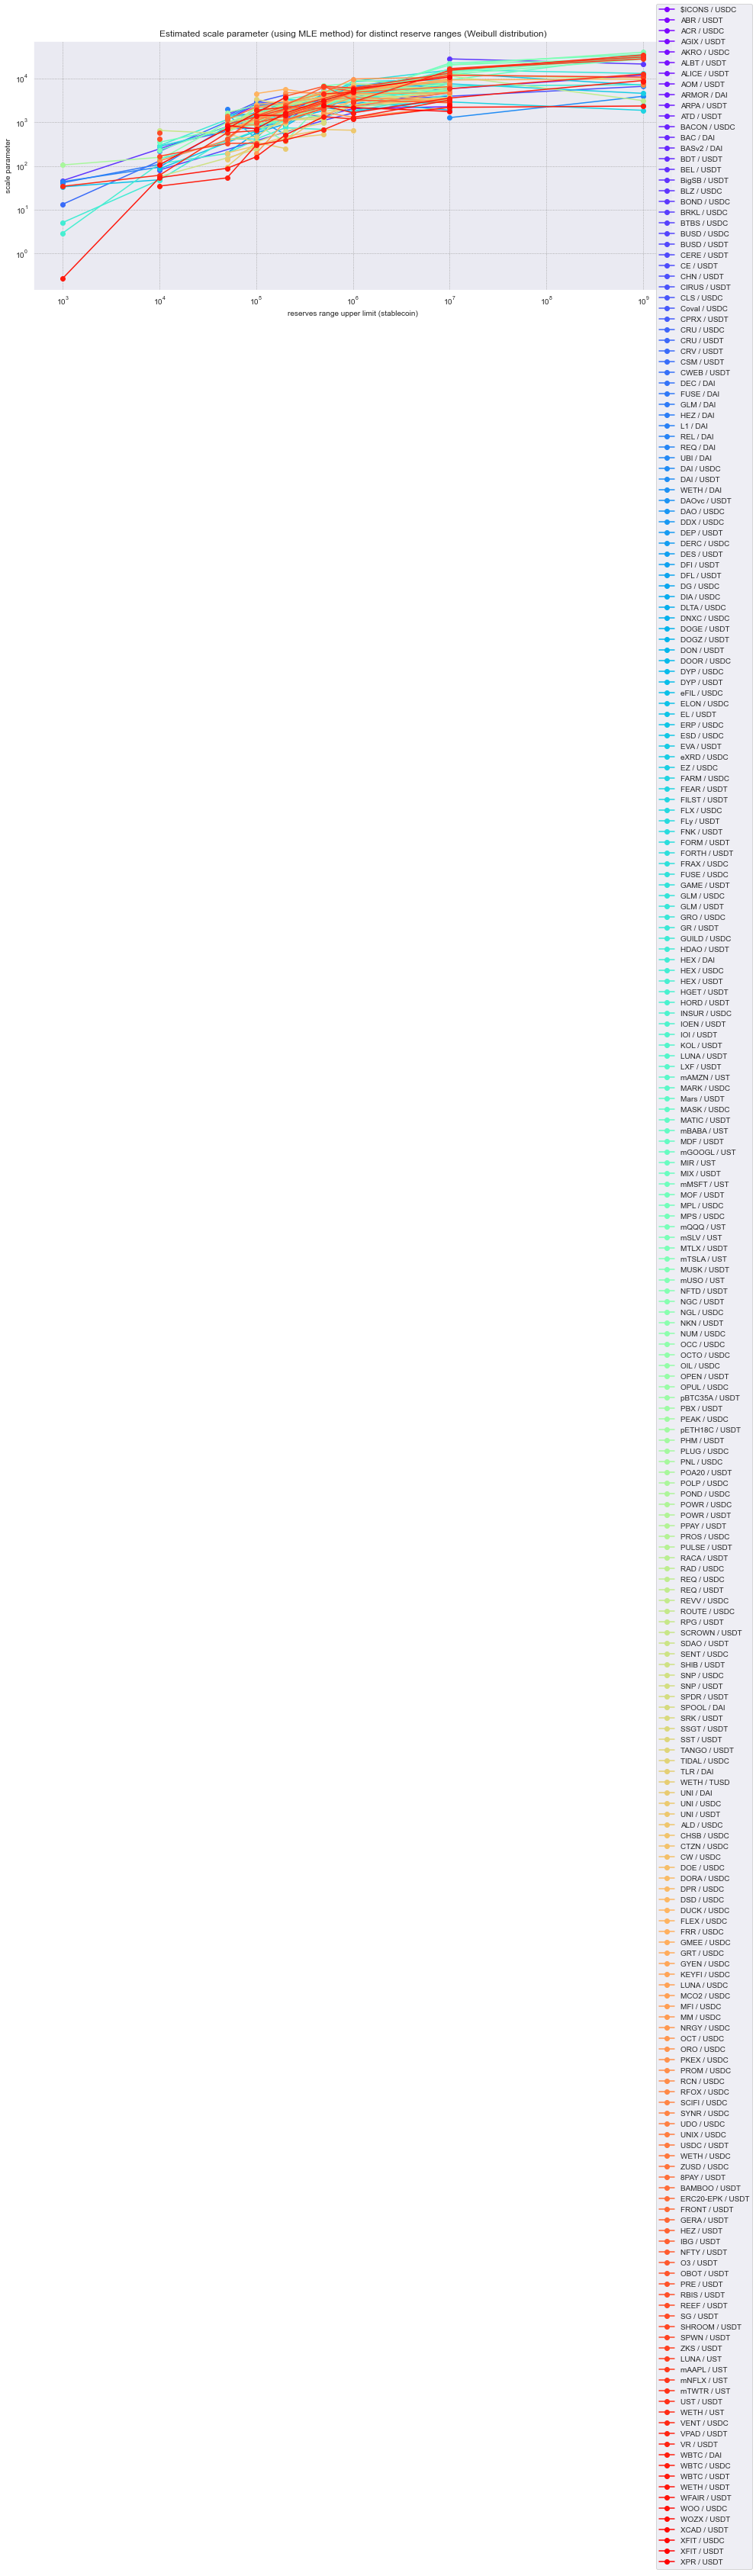

In [87]:
fig, ax = plt.subplots(figsize=(15, 6))
colors = cm.rainbow(np.linspace(0, 1, len(POOLS)))

filtered_all_stats_df = all_stats_df.copy()

for i in range(len(POOLS)):
    df = filtered_all_stats_df[filtered_all_stats_df['pool'] == (POOLS[i][0] + '/' + POOLS[i][1])]
    x = df['reserve_range_upper_limit']
    y = df['scale']
    
    if len(x) == 0:
        continue
    
    ax.plot(x, y, marker='o', label=f'{POOLS[i][0]} / {POOLS[i][1]}', color=colors[i])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('reserves range upper limit (stablecoin)')
ax.set_ylabel('scale parameter')
ax.set_title('Estimated scale parameter (using MLE method) for distinct reserve ranges (Weibull distribution)')

fig.legend()

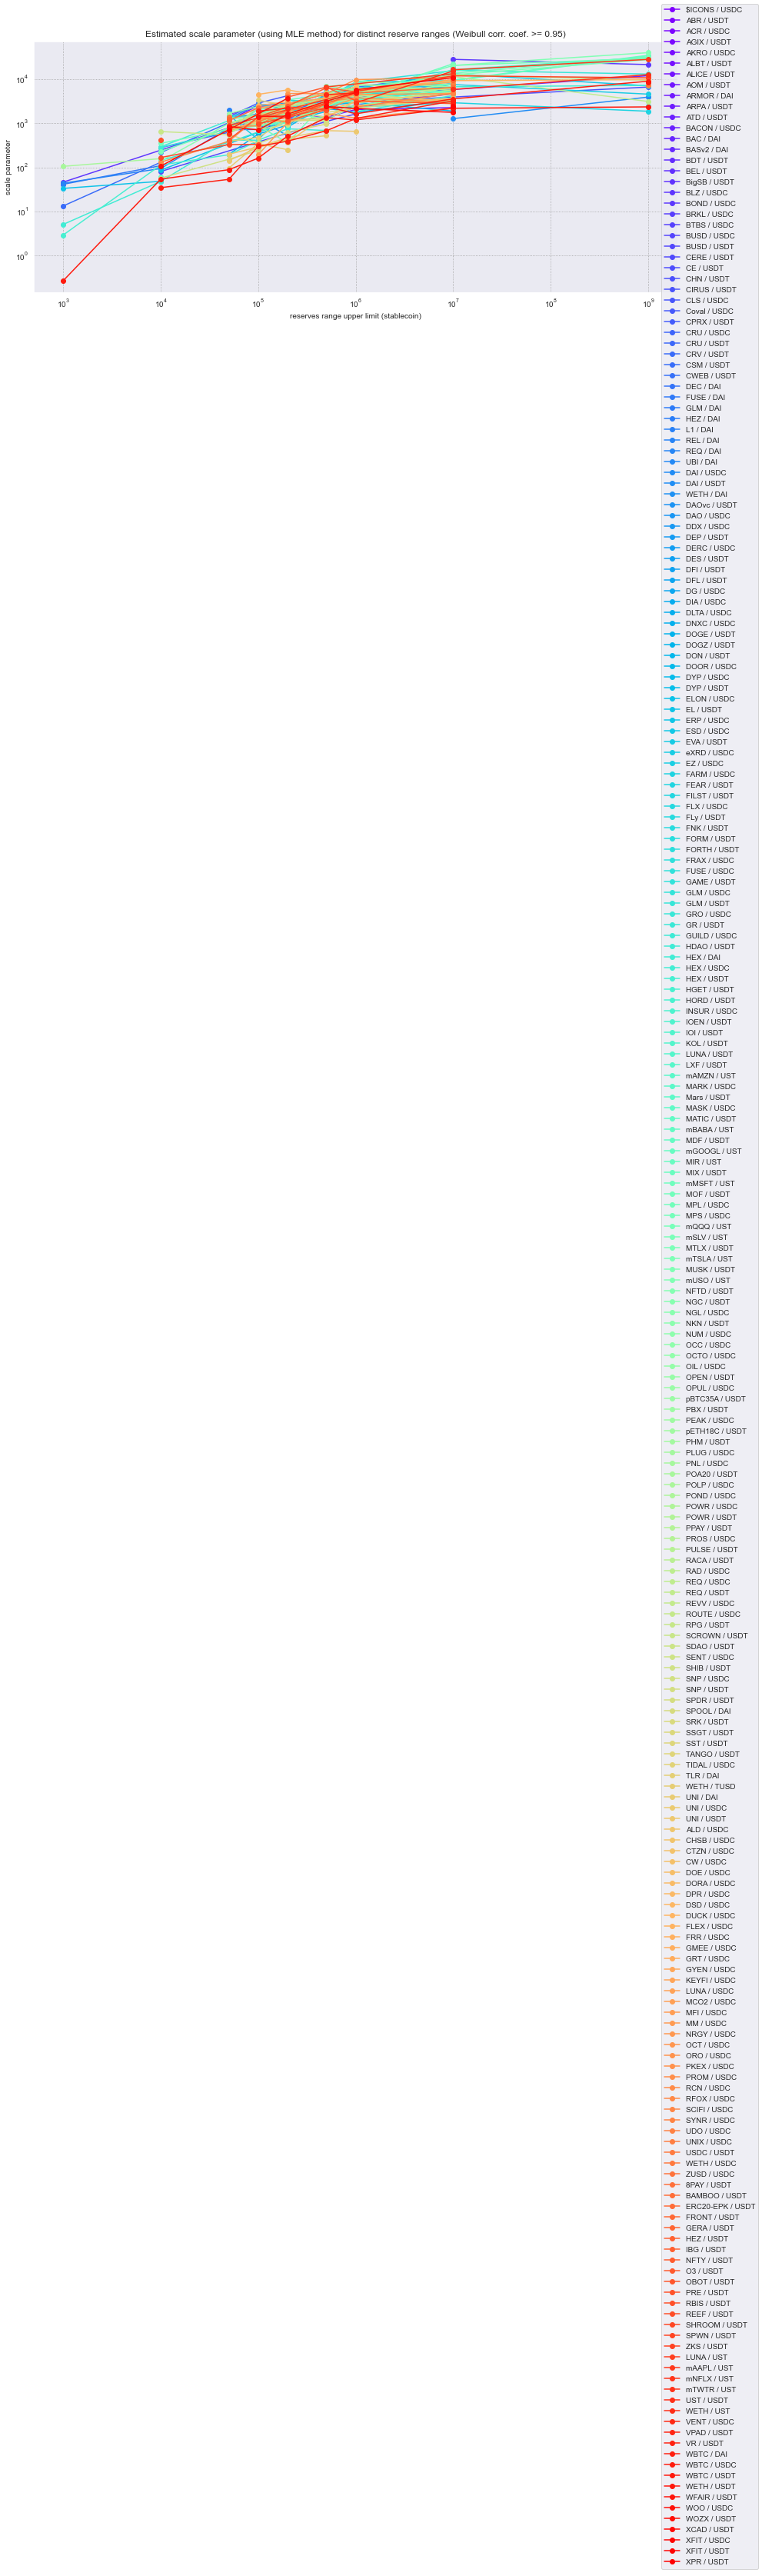

In [142]:
fig, ax = plt.subplots(figsize=(15, 6))
colors = cm.rainbow(np.linspace(0, 1, len(POOLS)))

filtered_all_stats_df = all_stats_df[all_stats_df.R2_weibull >= 0.9].copy()

for i in range(len(POOLS)):
    df = filtered_all_stats_df[filtered_all_stats_df.pool == POOLS[i][0] + '/' + POOLS[i][1]]
    x = df['reserve_range_upper_limit']
    y = df['scale']
    
    if len(x) == 0:
        continue
    
    ax.plot(x, y, marker='o', label=f'{POOLS[i][0]} / {POOLS[i][1]}', color=colors[i])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('reserves range upper limit (stablecoin)')
ax.set_ylabel('scale parameter')
ax.set_title('Estimated scale parameter (using MLE method) for distinct reserve ranges (Weibull corr. coef. >= 0.95)')

fig.legend()

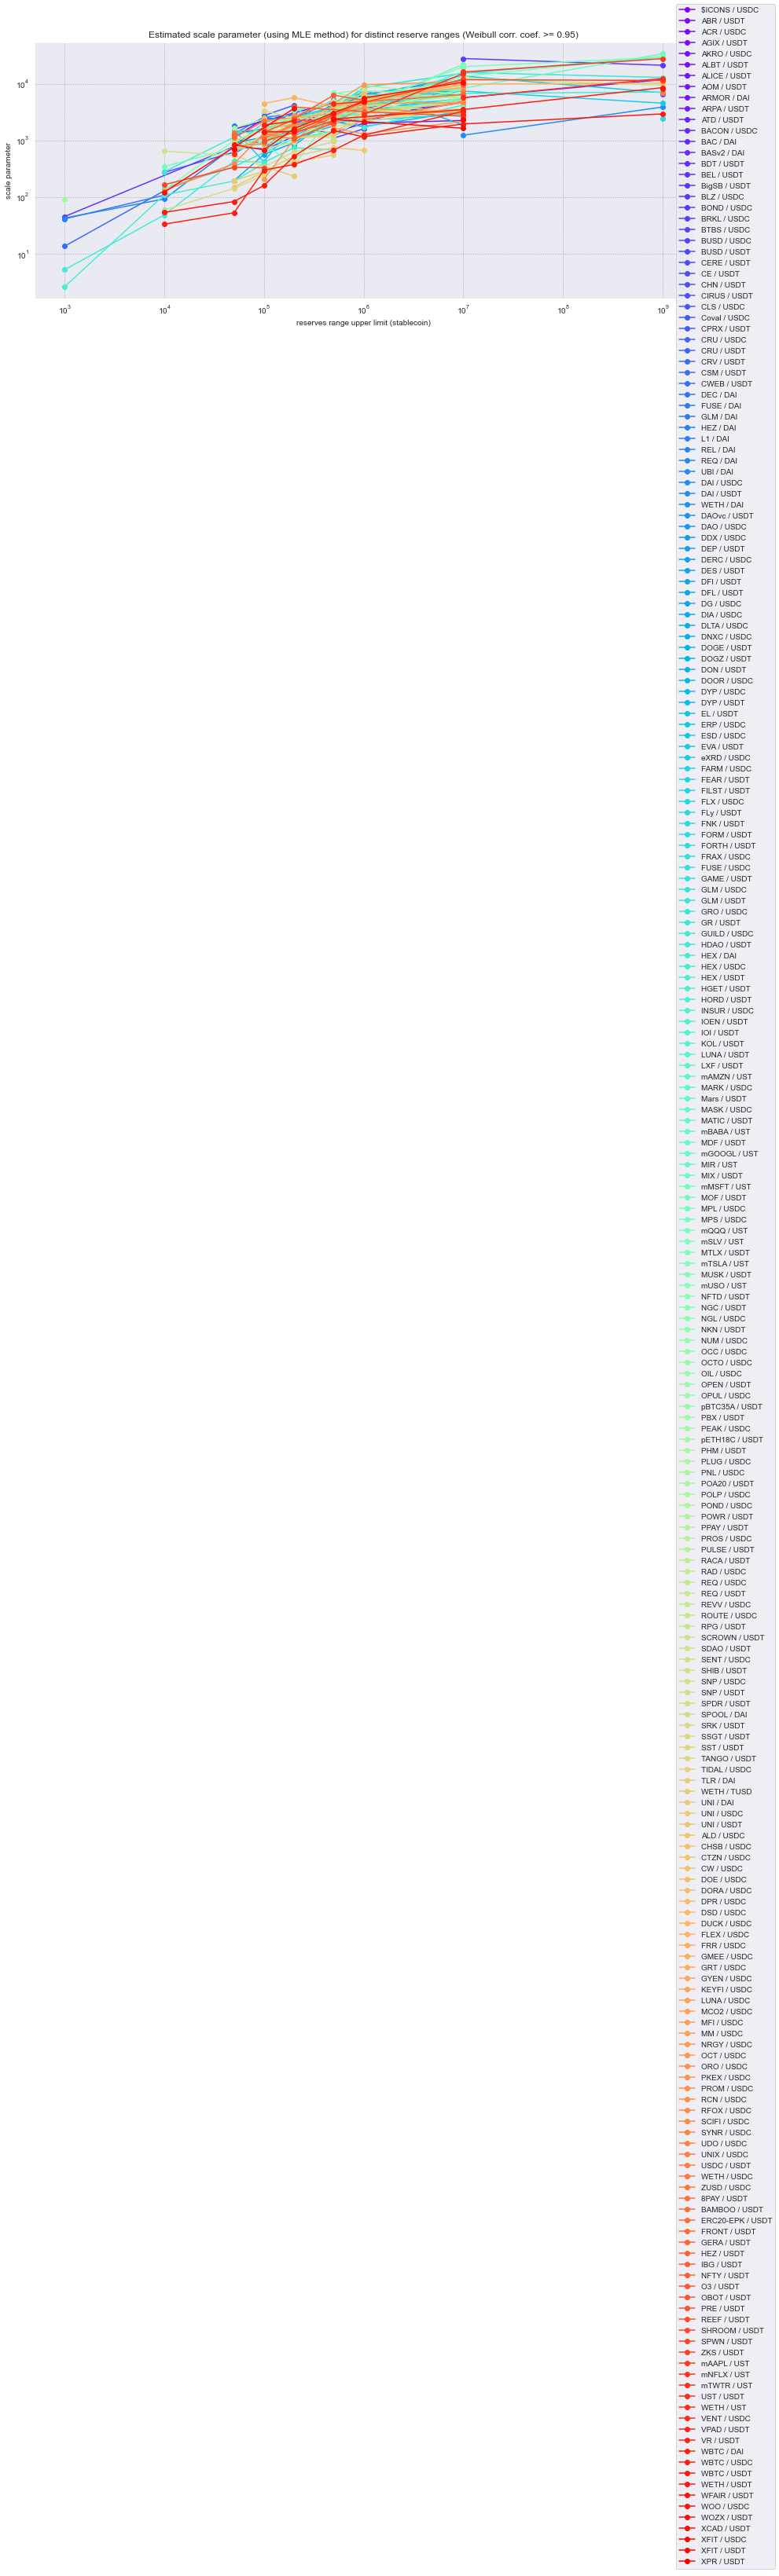

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))
colors = cm.rainbow(np.linspace(0, 1, len(POOLS)))

filtered_all_stats_df = all_stats_df[all_stats_df.R2_weibull >= 0.95].copy()

for i in range(len(POOLS)):
    df = filtered_all_stats_df[filtered_all_stats_df.pool == POOLS[i][0] + '/' + POOLS[i][1]]
    x = df['reserve_range_upper_limit']
    y = df['scale']
    
    if len(x) == 0:
        continue
    
    ax.plot(x, y, marker='o', label=f'{POOLS[i][0]} / {POOLS[i][1]}', color=colors[i])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('reserves range upper limit (stablecoin)')
ax.set_ylabel('scale parameter')
ax.set_title('Estimated scale parameter (using MLE method) for distinct reserve ranges (Weibull corr. coef. >= 0.95)')

fig.legend()

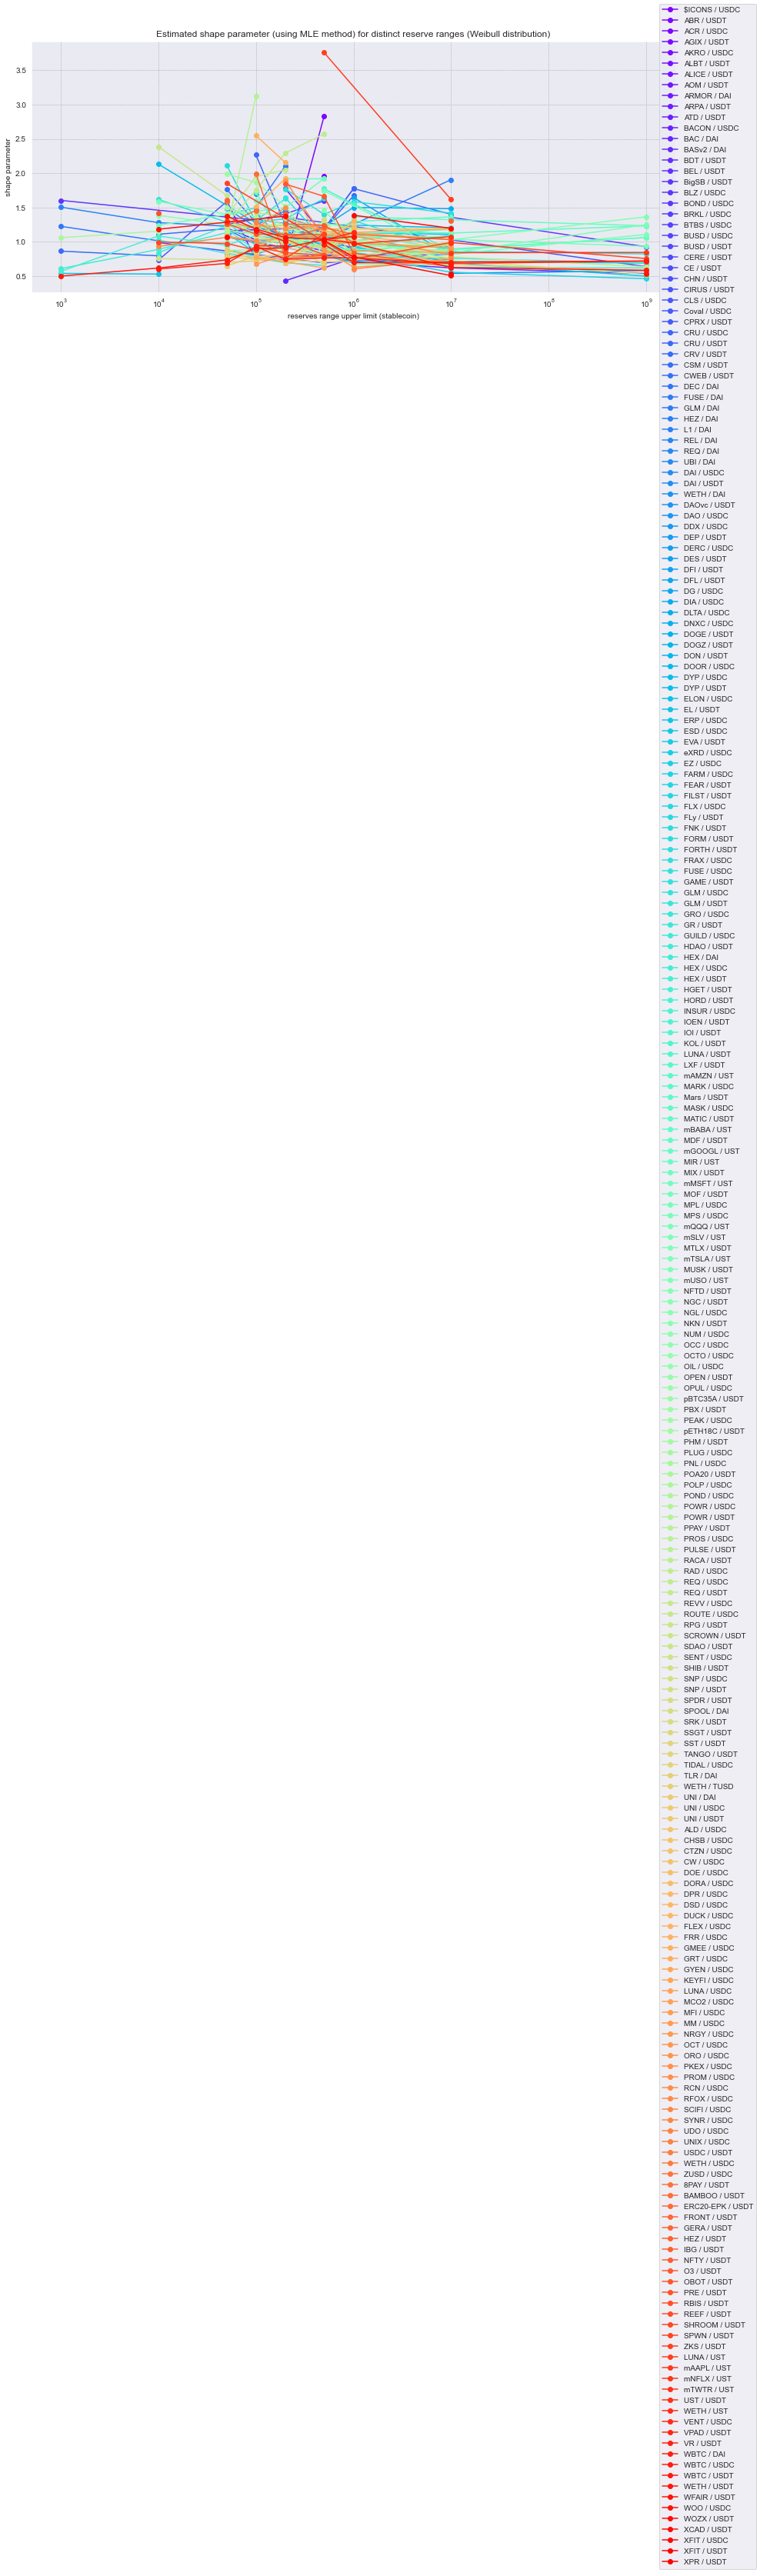

In [143]:
fig, ax = plt.subplots(figsize=(15, 6))
colors = cm.rainbow(np.linspace(0, 1, len(POOLS)))

filtered_all_stats_df = all_stats_df[all_stats_df.R2_weibull >= 0.9].copy()

for i in range(len(POOLS)):
    df = filtered_all_stats_df[filtered_all_stats_df.pool == POOLS[i][0] + '/' + POOLS[i][1]]
    x = df['reserve_range_upper_limit']
    y = df['shape']
    
    if len(x) == 0:
        continue
    
    ax.plot(x, y, marker='o', label=f'{POOLS[i][0]} / {POOLS[i][1]}', color=colors[i])

ax.set_xscale('log')

ax.set_title('Estimated shape parameter (using MLE method) for distinct reserve ranges (Weibull distribution)')
ax.set_xlabel('reserves range upper limit (stablecoin)')
ax.set_ylabel('shape parameter')

fig.legend()

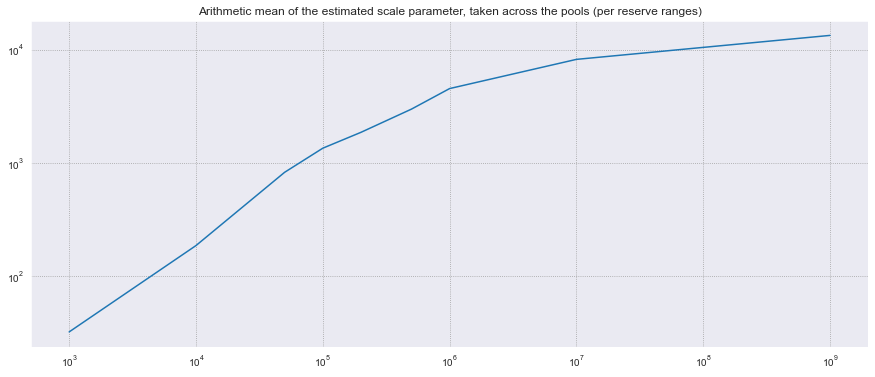

In [156]:
mean_params = all_stats_df[all_stats_df.R2_weibull >= 0.95].groupby('reserve_range_upper_limit').mean()[['scale', 'shape']]

x = mean_params.index
y = mean_params['scale']

fig, ax = plt.subplots(figsize=(15, 6))

ax.set_title('Arithmetic mean of the estimated scale parameter, taken across the pools (per reserve ranges)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, y)

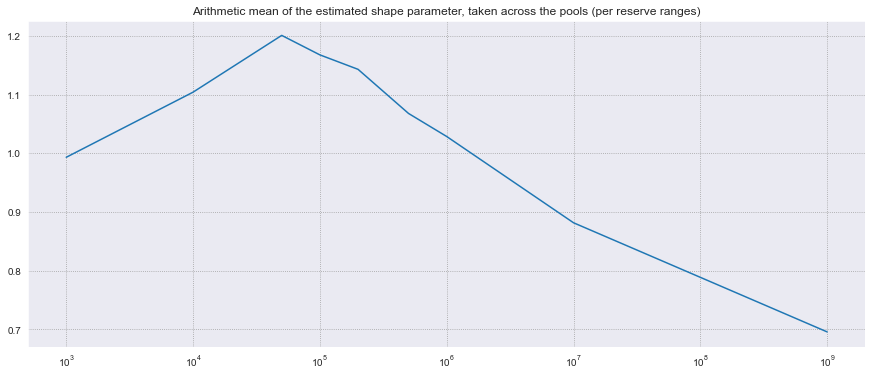

In [157]:
x = mean_params.index
y = mean_params['shape']

fig, ax = plt.subplots(figsize=(15, 6))

ax.set_title('Arithmetic mean of the estimated shape parameter, taken across the pools (per reserve ranges)')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(x, y)

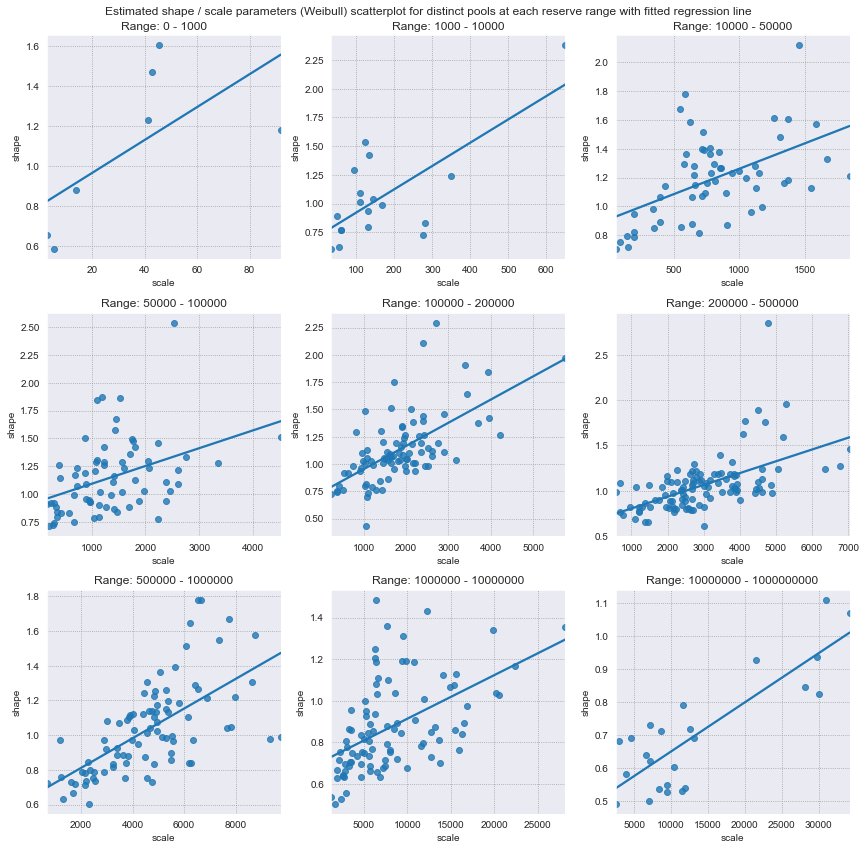

In [55]:
import math
import scipy

COLS = 3
ROWS = N_RANGES//COLS + (N_RANGES % COLS != 0)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
ax = ax.ravel()

params = []
scale_params = []
shape_params = []


for i, ab in enumerate(zip(BOUNDARIES[:-1], BOUNDARIES[1:])):
    a, b = ab
    
    x = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'scale'].values.reshape(-1, 1)
    y = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'shape'].values
    
    sns.regplot(x=x, y=y, ax=ax[i], ci=None)

    ax[i].set_title(f'Range: {BOUNDARIES[i]} - {BOUNDARIES[i + 1]}')
    ax[i].set_ylabel('shape')
    ax[i].set_xlabel('scale')
    
fig.suptitle('Estimated shape / scale parameters (Weibull) scatterplot for distinct pools at each reserve range with fitted regression line')
fig.tight_layout()

## Generalize distribution parameters

x_d 7.883792715824859
x_d 46.04458928516398
x_d 148.67332113532947
x_d 326.8979457272965
x_d 409.14336045610133
x_d 488.47174904946087
x_d 683.2130087540397
x_d 2013.407123112406
x_d 2368.4637496374407


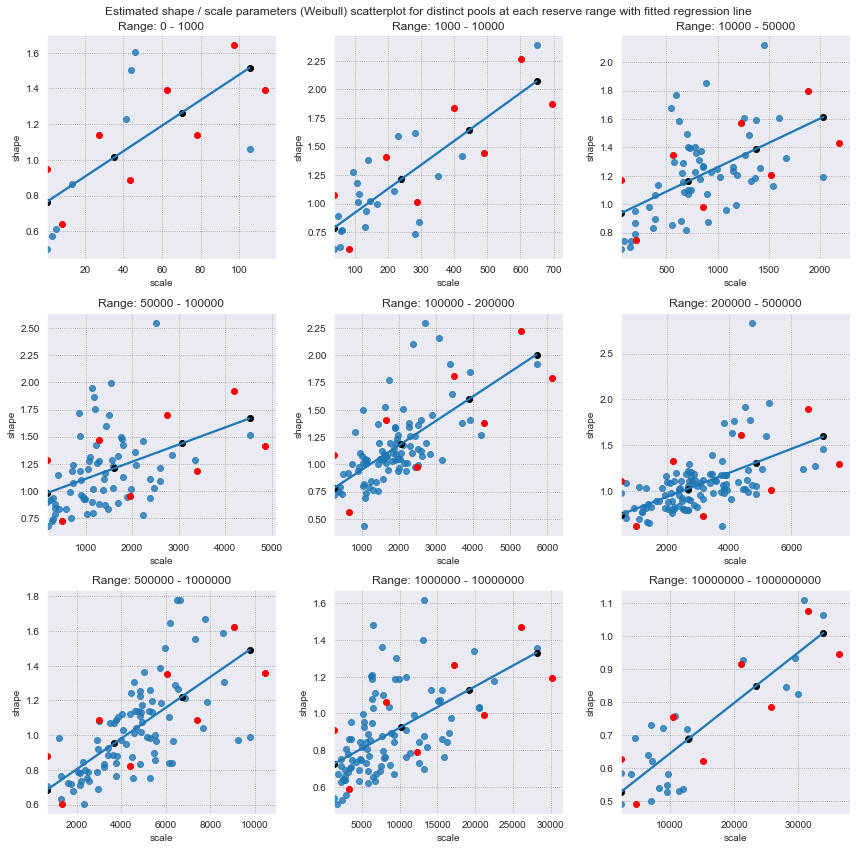

In [159]:
import math
import scipy

COLS = 3
ROWS = N_RANGES//COLS + (N_RANGES % COLS != 0)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
ax = ax.ravel()

params = []
scale_params = []
shape_params = []


for i, ab in enumerate(zip(BOUNDARIES[:-1], BOUNDARIES[1:])):
    a, b = ab
    X = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'scale'].values.reshape(-1, 1)
    y = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'shape'].values
    
    if len(X) < 3:
        continue

    reg = LinearRegression().fit(X, y)
    
  #  m  = reg.coef_[0]
    b = reg.intercept_
    
    f_reg = lambda x: reg.coef_[0]*x + reg.intercept_
  
    m2 = -reg.coef_[0]
    x_min = X.min()
    x_max = X.max()
    y_min = y.min()
    y_max = y.max()
    
    sns.regplot(x=X.flatten(), y=y, ax=ax[i], ci=None)

    ax[i].set_title(f'Range: {BOUNDARIES[i]} - {BOUNDARIES[i + 1]}')
    ax[i].set_ylabel('shape')
    ax[i].set_xlabel('scale')

    reserve_params = []
    reserve_scale_params = []
    reserve_shape_params = []

    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    x_range = (xmax-xmin)
    y_range = (ymax-ymin)
    
    x_d = x_range*0.075
    print('x_d', x_d)
    f_reg_above = lambda x: f_reg(x) + 0.15*y_range
    f_reg_bellow = lambda x: f_reg(x) - 0.15*y_range
    

    for x in np.linspace(x_min, x_max, 4):
        y = f_reg(x)
        
        x_bellow = x-x_d*(x != x_min)
        x_above = x+x_d
        
        y_above = f_reg_above(x_bellow)
        y_bellow = f_reg_bellow(x+x_d)
        y_bellow = max(y_bellow, y_min)
        
        b2 = y - m2*x
        
        ax[i].scatter([x], [y], color='black')
        ax[i].scatter([x_bellow], [y_above], color='red')
        ax[i].scatter([x_above], [y_bellow], color='red')

        
        reserve_scale_params.extend([x_above, x, x_bellow])
        reserve_shape_params.extend([y_bellow, y, y_above])

            
    #params.append(reserve_params)
    scale_params.append(reserve_scale_params)
    shape_params.append(reserve_shape_params)
    
fig.suptitle('Estimated shape / scale parameters (Weibull) scatterplot for distinct pools at each reserve range with fitted regression line')
fig.tight_layout()

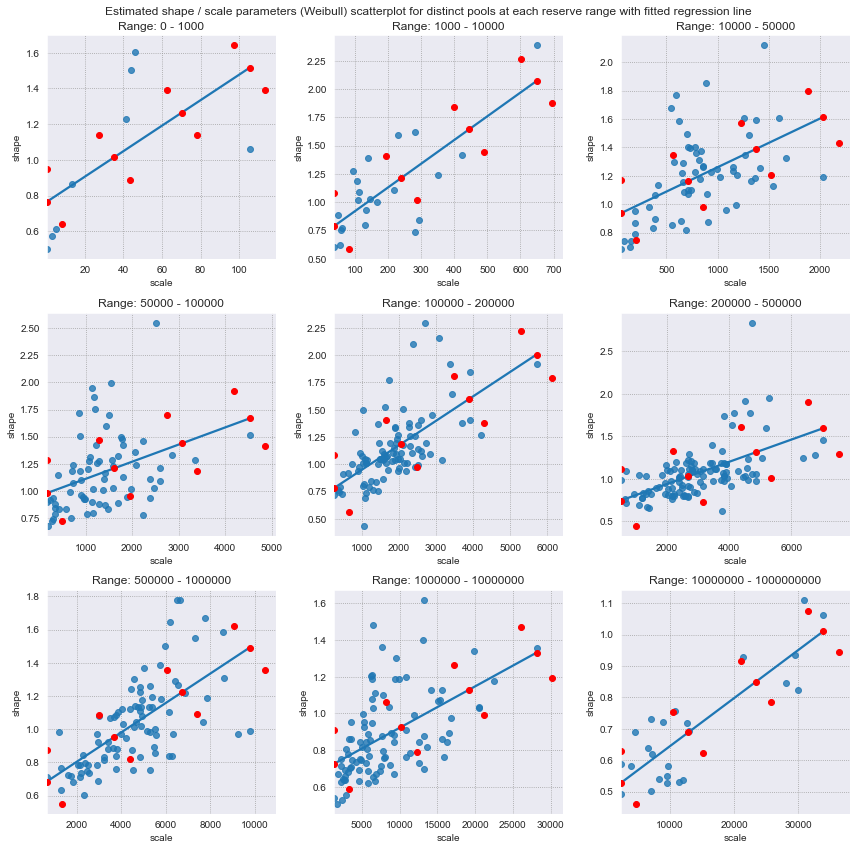

In [170]:
import math
import scipy

COLS = 3
ROWS = N_RANGES//COLS + (N_RANGES % COLS != 0)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
ax = ax.ravel()

params = []
scale_params = []
shape_params = []

for i, ab in enumerate(zip(BOUNDARIES[:-1], BOUNDARIES[1:])):
    a, b = ab
    X = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'scale'].values.reshape(-1, 1)
    y = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'shape'].values
    
    if len(X) < 3:
        continue

    reg = LinearRegression().fit(X, y)
    
    b = reg.intercept_
    
    f_reg = lambda x: reg.coef_[0]*x + reg.intercept_
  
    m2 = -reg.coef_[0]
    x_min = X.min()
    x_max = X.max()
    y_min = y.min()
    y_max = y.max()
    
    sns.regplot(x=X.flatten(), y=y, ax=ax[i], ci=None)

    ax[i].set_title(f'Range: {BOUNDARIES[i]} - {BOUNDARIES[i + 1]}')
    ax[i].set_ylabel('shape')
    ax[i].set_xlabel('scale')

    reserve_params = []
    reserve_scale_params = []
    reserve_shape_params = []

    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    x_range = (xmax-xmin)
    y_range = (ymax-ymin)
    
    x_d = x_range*0.075
    f_reg_above = lambda x: f_reg(x) + 0.15*y_range
    f_reg_bellow = lambda x: f_reg(x) - 0.15*y_range
    

    for x in np.linspace(x_min, x_max, 4):
        y = f_reg(x)
        
        x_bellow = x-x_d*(x != x_min)
        x_above = x+x_d
        
        y_above = f_reg_above(x_bellow)
        y_bellow = f_reg_bellow(x+x_d)
        
        ax[i].scatter([x], [y], color='red', zorder=10)
        ax[i].scatter([x_bellow], [y_above], color='red')
        ax[i].scatter([x_above], [y_bellow], color='red')
        
        reserve_scale_params.extend([x_above, x, x_bellow])
        reserve_shape_params.extend([y_bellow, y, y_above])
            
    scale_params.append(reserve_scale_params)
    shape_params.append(reserve_shape_params)
    
fig.suptitle('Estimated shape / scale parameters (Weibull) scatterplot for distinct pools at each reserve range with fitted regression line')
fig.tight_layout()

[  0.26799005  35.30706879  70.34614753 105.38522626] [0.50176772 0.86919913 1.23663055 1.60406196]
[ 34.62415235 239.26677139 443.90939044 648.55200948] [0.60508903 1.19853448 1.79197994 2.38542539]
[  53.41836892  714.18868508 1374.95900123 2035.72931739] [0.68595308 1.16329538 1.64063768 2.11797998]
[ 161.61277551 1614.4925343  3067.37229309 4520.25205188] [0.67584884 1.29983277 1.92381671 2.54780065]
[ 250.93524689 2069.35018225 3887.76511761 5706.18005297] [0.43392755 1.05422195 1.67451634 2.29481074]
[ 522.66138345 2693.64693478 4864.63248611 7035.61803745] [0.61983265 1.35774969 2.09566673 2.83358376]
[ 655.96151846 3692.46377959 6728.96604072 9765.46830184] [0.60569346 0.9959891  1.38628474 1.77658037]
[ 1274.48502793 10222.96113066 19171.43723338 28119.9133361 ] [0.50905486 0.87816578 1.2472767  1.61638762]
[ 2350.68931656 12877.19487051 23403.70042445 33930.2059784 ] [0.49211482 0.6977351  0.90335538 1.10897565]


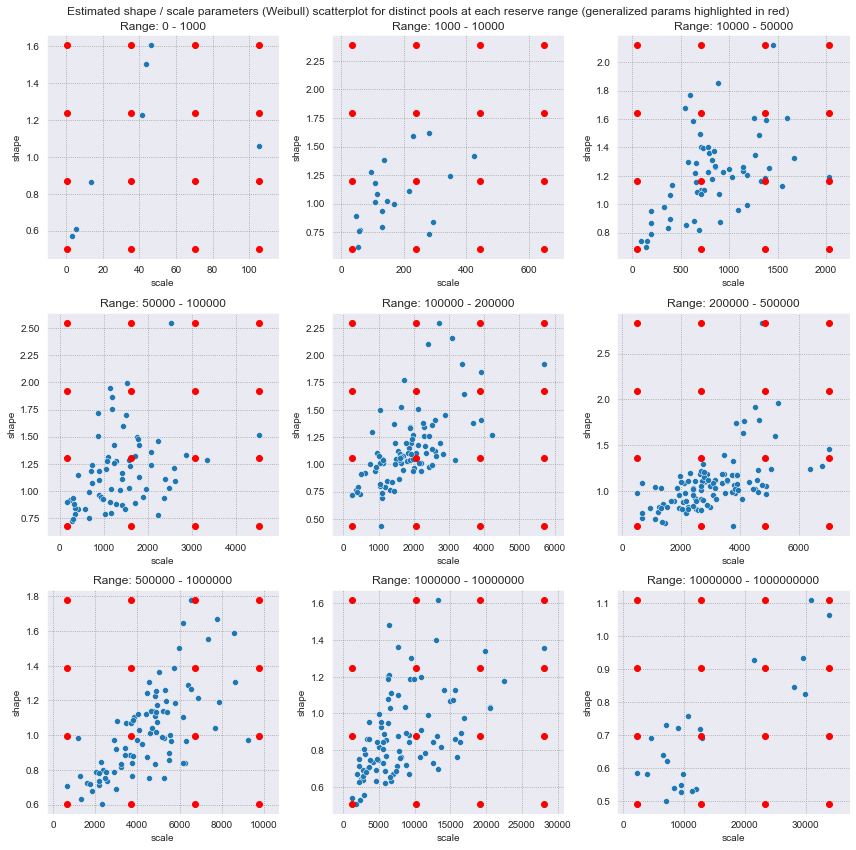

In [166]:
import math
import scipy
import itertools

COLS = 3
ROWS = N_RANGES//COLS + (N_RANGES % COLS != 0)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*4, ROWS*4))
ax = ax.ravel()

params = []
scale_params = []
shape_params = []

for i, ab in enumerate(zip(BOUNDARIES[:-1], BOUNDARIES[1:])):
    a, b = ab
    X = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'scale'].values.reshape(-1, 1)
    y = all_stats_df.loc[(all_stats_df.reserve_range_upper_limit == b) & (all_stats_df.R2_weibull >= 0.95), 'shape'].values
    
    if len(X) < 3:
        continue

    reg = LinearRegression().fit(X, y)
    
    b = reg.intercept_
    
    f_reg = lambda x: reg.coef_[0]*x + reg.intercept_
  
    m2 = -reg.coef_[0]
    x_min = X.min()
    x_max = X.max()
    y_min = y.min()
    y_max = y.max()
    
    ab = itertools.product(np.linspace(x_min, x_max, 4), np.linspace(y_min, y_max, 4))
    print(np.linspace(x_min, x_max, 4), np.linspace(y_min, y_max, 4))
    sns.scatterplot(x=X.flatten(), y=y, ax=ax[i], ci=None)

    ax[i].set_title(f'Range: {BOUNDARIES[i]} - {BOUNDARIES[i + 1]}')
    ax[i].set_ylabel('shape')
    ax[i].set_xlabel('scale')

    reserve_params = []
    reserve_scale_params = []
    reserve_shape_params = []

    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    x_range = (xmax-xmin)
    y_range = (ymax-ymin)
    
    x_d = x_range*0.075
    f_reg_above = lambda x: f_reg(x) + 0.15*y_range
    f_reg_bellow = lambda x: f_reg(x) - 0.15*y_range
    
    ax[i].set_xlim(xmin - (xmax - xmin)*0.05, xmax + (xmax - xmin)*0.05)
    
    for a, b in ab:
        ax[i].scatter([a], [b], color='red', zorder=10)
        
        reserve_scale_params.extend([a])
        reserve_shape_params.extend([b])
            
    scale_params.append(reserve_scale_params)
    shape_params.append(reserve_shape_params)
    
fig.suptitle('Estimated shape / scale parameters (Weibull) scatterplot for distinct pools at each reserve range (generalized params highlighted in red)')
fig.tight_layout()

## Save parameters

In [171]:
config_list = []
for i, reserve_range in enumerate(zip(BOUNDARIES[:-1], BOUNDARIES[1:])):
    a, b = reserve_range

    config = {}
    config['reserve_range'] = [a, b]
    
    config['scale'] = np.array(scale_params[i]).flatten().tolist()
    config['shape'] = np.array(shape_params[i]).flatten().tolist()

    print(a, b)
    config_list.append(config)

0 1000
1000 10000
10000 50000
50000 100000
100000 200000
200000 500000
500000 1000000
1000000 10000000
10000000 1000000000


In [172]:
config_str = json.dumps(config_list)

with open('parameters.json', 'w') as f:
    f.write(config_str)